In [70]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix


In [71]:
import os
import pandas as pd
import json
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    balanced_accuracy_score, f1_score  # <<< NEW >>>
)
import re

In [72]:
df_gemini = pd.read_csv('/mnt/teams/TM_Lab/Tony/wr_new/analysis_scripts/gemap/results/direct_comparisons__22.csv')

df_gemini['filename'] = df_gemini['filename'].apply(lambda x: x.split('_B')[0])

In [73]:
df_gemini = df_gemini[['filename','phase','Stroke']]

In [89]:

path1 = '/mnt/teams/TM_Lab/Tony/wr_new/data_used/tta_gcamp8s/hand_scored'
path2 = '/mnt/teams/TM_Lab/Tony/wr_new/analysis_scripts/anipose/Hao_labelling'

# --- Create the first dictionary for the 'hand_scored' files ---
hand_scored_data = {} # Initialize an empty dictionary
# Loop through every file in the first directory
for filename in os.listdir(path1):
    # We only care about CSV files
    if filename.endswith('.csv'):
        # Create the full path to the file
        file_path = os.path.join(path1, filename)
        try:
            # Use the filename as the key and the loaded CSV data (a DataFrame) as the value
            hand_scored_data[filename] = pd.read_csv(file_path)
            #print(f"  - Loaded: {filename}")
        except Exception as e:
            print(f"  - FAILED to load {filename}. Error: {e}")
hand_scored_data2 = {} # Initialize the second empty dictionary

# Loop through every file in the second directory
for filename in os.listdir(path2):
    if filename.endswith('.csv'):
        file_path = os.path.join(path2, filename)
        try:
            cleaned = re.sub(r'_scored(?=\.csv$)', '', filename)
            hand_scored_data2[cleaned] = pd.read_csv(file_path)
            #print(f"  - Loaded: {filename}")
        except Exception as e:
            print(f"  - FAILED to load {filename}. Error: {e}")
print("Processing 'hand_scored_data' to simplify outcomes...")
hand_scored_mapping = {
    'ps': 's',
    'rnd': 'f'
}
for filename, df in hand_scored_data.items():
    if 'outcome' in df.columns:
        df['outcome'] = df['outcome'].replace(hand_scored_mapping)
    else:
        print(f"  - WARNING: 'outcome' column not found in {filename}")
print("Simplification of all hand-scored data is complete.\n")


for filename, df in hand_scored_data2.items():
    if 'outcome' in df.columns:
        df['outcome'] = df['outcome'].replace(hand_scored_mapping)
    else:
        print(f"  - WARNING: 'outcome' column not found in {filename}")
print("Simplification of all hand-scored data is complete.\n")

Processing 'hand_scored_data' to simplify outcomes...
Simplification of all hand-scored data is complete.

Simplification of all hand-scored data is complete.




📊 COHEN'S KAPPA BY EXPERIMENTAL GROUP

Pre_or_NoStroke:
  n = 16 sessions
  Mean κ: 0.693 ± 0.057 (SEM)
  Median κ: 0.751
  Range: [0.000, 0.955]
  Sessions with κ < 0.60: 4/16

Early_Stroke:
  n = 5 sessions
  Mean κ: 0.831 ± 0.076 (SEM)
  Median κ: 0.831
  Range: [0.628, 1.000]
  Sessions with κ < 0.60: 0/5

Late_Stroke:
  n = 5 sessions
  Mean κ: 0.700 ± 0.047 (SEM)
  Median κ: 0.719
  Range: [0.529, 0.808]
  Sessions with κ < 0.60: 1/5

📈 STATISTICAL COMPARISON (Kruskal-Wallis Test)
H-statistic: 1.887
p-value: 0.3892
✗ No significant difference between groups (p ≥ 0.05)

✅ Plot saved to kappa_by_groups.png


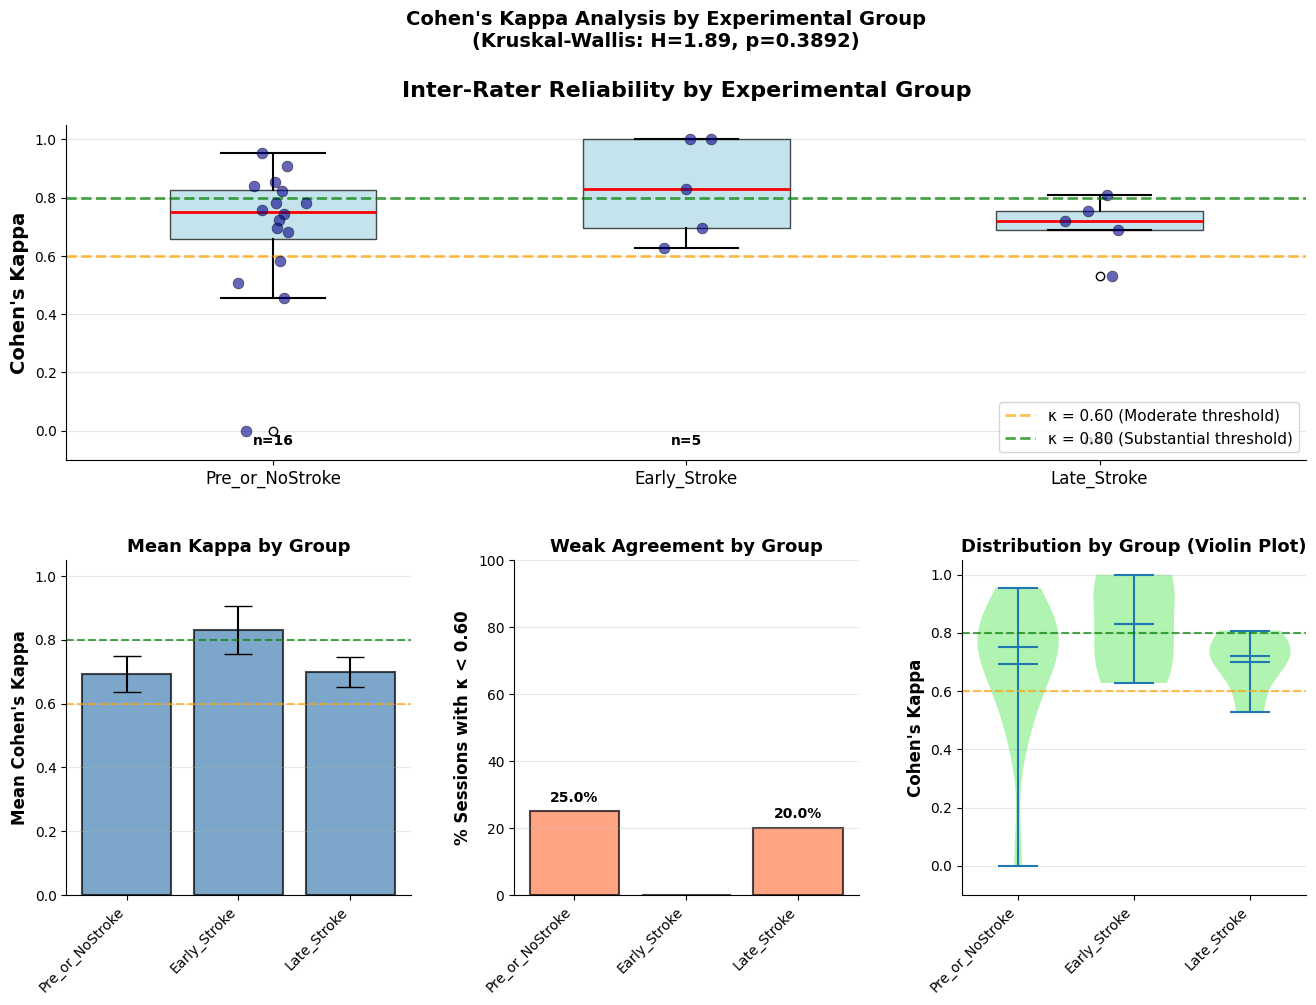

✅ Plot saved to kappa_by_phase_and_stroke.png


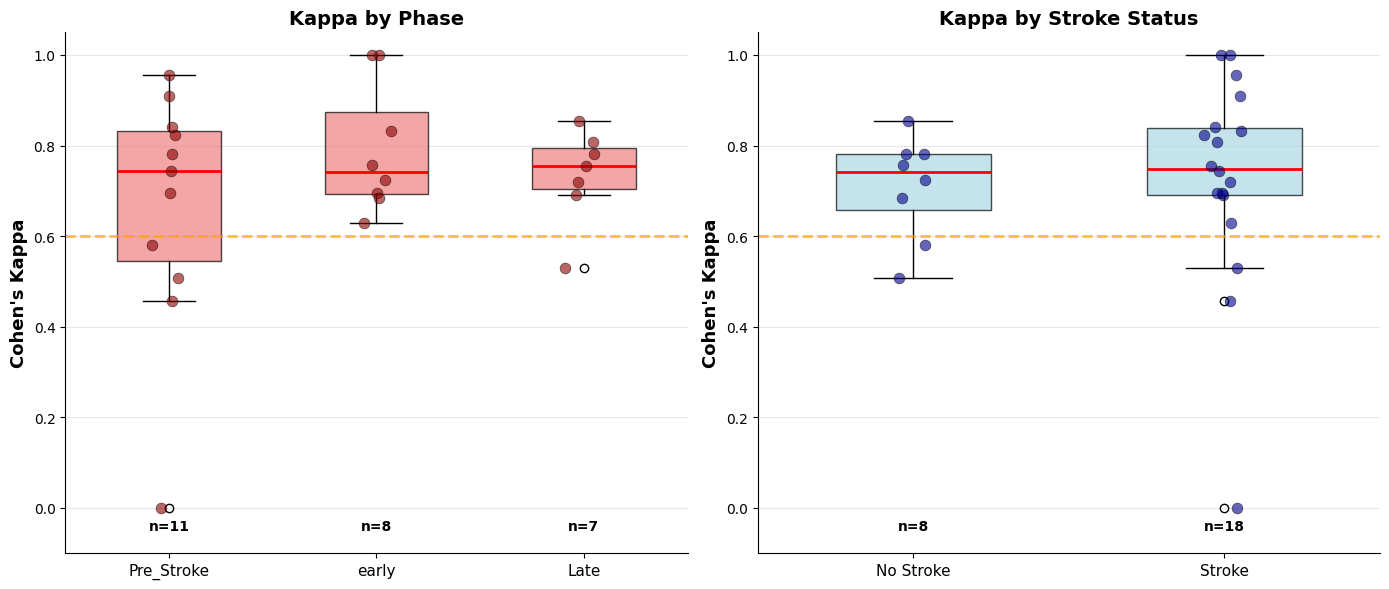


📊 KAPPA BY PHASE

Pre_Stroke:
  Mean: 0.663 ± 0.082
  n: 11

early:
  Mean: 0.790 ± 0.050
  n: 8

Late:
  Mean: 0.734 ± 0.040
  n: 7

📊 KAPPA BY STROKE STATUS

No Stroke:
  Mean: 0.709 ± 0.041
  n: 8

Stroke:
  Mean: 0.727 ± 0.055
  n: 18


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_kappa_by_groups(comparison_results, groups_df, save_path=None):
    """
    Plot Cohen's Kappa by experimental groups (phase and stroke status).
    
    Args:
        comparison_results: Output from compare_hand_scorers()
        groups_df: DataFrame with columns ['filename', 'phase', 'Stroke']
        save_path: Optional path to save the plot
    """
    # Get kappa results
    results_df = comparison_results['results_per_file']
    
    # Merge with groups
    merged = results_df.merge(groups_df, on='filename', how='left')
    
    # Create combined group
    merged['group'] = 'Other'
    merged.loc[(merged['phase'] == 'Pre_Stroke') | (merged['Stroke'] == 'n'), 'group'] = 'Pre_or_NoStroke'
    merged.loc[(merged['phase'] == 'early') & (merged['Stroke'] == 'y'), 'group'] = 'Early_Stroke'
    merged.loc[(merged['phase'] == 'Late') & (merged['Stroke'] == 'y'), 'group'] = 'Late_Stroke'
    
    # Define group order
    group_order = ['Pre_or_NoStroke', 'Early_Stroke', 'Late_Stroke']
    
    # Print summary statistics
    print("\n" + "="*80)
    print("📊 COHEN'S KAPPA BY EXPERIMENTAL GROUP")
    print("="*80)
    
    for group in group_order:
        group_data = merged[merged['group'] == group]
        if len(group_data) > 0:
            print(f"\n{group}:")
            print(f"  n = {len(group_data)} sessions")
            print(f"  Mean κ: {group_data['cohen_kappa'].mean():.3f} ± {group_data['cohen_kappa'].sem():.3f} (SEM)")
            print(f"  Median κ: {group_data['cohen_kappa'].median():.3f}")
            print(f"  Range: [{group_data['cohen_kappa'].min():.3f}, {group_data['cohen_kappa'].max():.3f}]")
            print(f"  Sessions with κ < 0.60: {(group_data['cohen_kappa'] < 0.60).sum()}/{len(group_data)}")
    
    # Statistical comparison
    print("\n" + "="*80)
    print("📈 STATISTICAL COMPARISON (Kruskal-Wallis Test)")
    print("="*80)
    
    groups_for_test = [merged[merged['group'] == g]['cohen_kappa'].values for g in group_order]
    h_stat, p_value = stats.kruskal(*groups_for_test)
    
    print(f"H-statistic: {h_stat:.3f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("✓ Significant difference between groups (p < 0.05)")
    else:
        print("✗ No significant difference between groups (p ≥ 0.05)")
    
    # Create comprehensive figure
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # 1. Box plot with individual points
    ax1 = fig.add_subplot(gs[0, :])
    
    # Prepare data for plotting
    plot_data = merged[merged['group'].isin(group_order)]
    
    # Box plot
    bp = ax1.boxplot(
        [plot_data[plot_data['group'] == g]['cohen_kappa'].values for g in group_order],
        positions=range(len(group_order)),
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', alpha=0.7),
        medianprops=dict(color='red', linewidth=2),
        whiskerprops=dict(linewidth=1.5),
        capprops=dict(linewidth=1.5)
    )
    
    # Add individual points with jitter
    for i, group in enumerate(group_order):
        group_data = plot_data[plot_data['group'] == group]['cohen_kappa'].values
        x_jitter = np.random.normal(i, 0.04, size=len(group_data))
        ax1.scatter(x_jitter, group_data, alpha=0.6, s=60, 
                   color='darkblue', edgecolor='black', linewidth=0.5, zorder=3)
    
    # Styling
    ax1.axhline(y=0.60, color='orange', linestyle='--', linewidth=2, 
               alpha=0.7, label='κ = 0.60 (Moderate threshold)')
    ax1.axhline(y=0.80, color='green', linestyle='--', linewidth=2, 
               alpha=0.7, label='κ = 0.80 (Substantial threshold)')
    
    ax1.set_ylabel("Cohen's Kappa", fontsize=14, fontweight='bold')
    ax1.set_title("Inter-Rater Reliability by Experimental Group", fontsize=16, fontweight='bold', pad=20)
    ax1.set_xticks(range(len(group_order)))
    ax1.set_xticklabels(group_order, fontsize=12)
    ax1.set_ylim(-0.1, 1.05)
    ax1.legend(fontsize=11, loc='lower right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add sample sizes
    for i, group in enumerate(group_order):
        n = len(plot_data[plot_data['group'] == group])
        ax1.text(i, -0.05, f'n={n}', ha='center', fontsize=10, fontweight='bold')
    
    sns.despine(ax=ax1)
    
    # 2. Mean kappa with error bars
    ax2 = fig.add_subplot(gs[1, 0])
    
    means = [merged[merged['group'] == g]['cohen_kappa'].mean() for g in group_order]
    sems = [merged[merged['group'] == g]['cohen_kappa'].sem() for g in group_order]
    
    bars = ax2.bar(range(len(group_order)), means, yerr=sems, 
                   capsize=10, color='steelblue', alpha=0.7, 
                   edgecolor='black', linewidth=1.5)
    
    ax2.axhline(y=0.60, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
    ax2.axhline(y=0.80, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax2.set_ylabel("Mean Cohen's Kappa", fontsize=12, fontweight='bold')
    ax2.set_title('Mean Kappa by Group', fontsize=13, fontweight='bold')
    ax2.set_xticks(range(len(group_order)))
    ax2.set_xticklabels(group_order, rotation=45, ha='right', fontsize=10)
    ax2.set_ylim(0, 1.05)
    ax2.grid(axis='y', alpha=0.3)
    sns.despine(ax=ax2)
    
    # 3. Proportion of weak agreement sessions by group
    ax3 = fig.add_subplot(gs[1, 1])
    
    weak_props = []
    for group in group_order:
        group_data = merged[merged['group'] == group]
        if len(group_data) > 0:
            weak_prop = (group_data['cohen_kappa'] < 0.60).sum() / len(group_data)
            weak_props.append(weak_prop * 100)
        else:
            weak_props.append(0)
    
    bars = ax3.bar(range(len(group_order)), weak_props, 
                   color='coral', alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax3.set_ylabel('% Sessions with κ < 0.60', fontsize=12, fontweight='bold')
    ax3.set_title('Weak Agreement by Group', fontsize=13, fontweight='bold')
    ax3.set_xticks(range(len(group_order)))
    ax3.set_xticklabels(group_order, rotation=45, ha='right', fontsize=10)
    ax3.set_ylim(0, 100)
    ax3.grid(axis='y', alpha=0.3)
    
    # Add percentages on bars
    for i, (bar, prop) in enumerate(zip(bars, weak_props)):
        if prop > 0:
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                    f'{prop:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    sns.despine(ax=ax3)
    
    # 4. Violin plot
    ax4 = fig.add_subplot(gs[1, 2])
    
    # Create violin plot
    parts = ax4.violinplot(
        [plot_data[plot_data['group'] == g]['cohen_kappa'].values for g in group_order],
        positions=range(len(group_order)),
        widths=0.7,
        showmeans=True,
        showmedians=True
    )
    
    # Color violins
    for pc in parts['bodies']:
        pc.set_facecolor('lightgreen')
        pc.set_alpha(0.7)
    
    # Add reference lines
    ax4.axhline(y=0.60, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
    ax4.axhline(y=0.80, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax4.set_ylabel("Cohen's Kappa", fontsize=12, fontweight='bold')
    ax4.set_title('Distribution by Group (Violin Plot)', fontsize=13, fontweight='bold')
    ax4.set_xticks(range(len(group_order)))
    ax4.set_xticklabels(group_order, rotation=45, ha='right', fontsize=10)
    ax4.set_ylim(-0.1, 1.05)
    ax4.grid(axis='y', alpha=0.3)
    sns.despine(ax=ax4)
    
    plt.suptitle(f'Cohen\'s Kappa Analysis by Experimental Group\n' + 
                 f'(Kruskal-Wallis: H={h_stat:.2f}, p={p_value:.4f})',
                 fontsize=14, fontweight='bold', y=0.995)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ Plot saved to {save_path}")
    
    plt.show()
    
    return merged


def plot_kappa_by_phase_and_stroke(comparison_results, groups_df, save_path=None):
    """
    Create a 2x2 breakdown by Phase and Stroke status separately.
    """
    # Get kappa results
    results_df = comparison_results['results_per_file']
    
    # Merge with groups
    merged = results_df.merge(groups_df, on='filename', how='left')
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. By Phase
    ax = axes[0]
    
    phase_order = ['Pre_Stroke', 'early', 'Late']
    phase_data = merged[merged['phase'].isin(phase_order)]
    
    bp = ax.boxplot(
        [phase_data[phase_data['phase'] == p]['cohen_kappa'].values for p in phase_order],
        positions=range(len(phase_order)),
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor='lightcoral', alpha=0.7),
        medianprops=dict(color='red', linewidth=2)
    )
    
    # Add points
    for i, phase in enumerate(phase_order):
        data = phase_data[phase_data['phase'] == phase]['cohen_kappa'].values
        x_jitter = np.random.normal(i, 0.04, size=len(data))
        ax.scatter(x_jitter, data, alpha=0.6, s=60, color='darkred', 
                  edgecolor='black', linewidth=0.5, zorder=3)
    
    ax.axhline(y=0.60, color='orange', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_ylabel("Cohen's Kappa", fontsize=13, fontweight='bold')
    ax.set_title('Kappa by Phase', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(phase_order)))
    ax.set_xticklabels(phase_order, fontsize=11)
    ax.set_ylim(-0.1, 1.05)
    ax.grid(axis='y', alpha=0.3)
    
    # Add sample sizes
    for i, phase in enumerate(phase_order):
        n = len(phase_data[phase_data['phase'] == phase])
        ax.text(i, -0.05, f'n={n}', ha='center', fontsize=10, fontweight='bold')
    
    sns.despine(ax=ax)
    
    # 2. By Stroke Status
    ax = axes[1]
    
    stroke_order = ['n', 'y']
    stroke_labels = ['No Stroke', 'Stroke']
    stroke_data = merged[merged['Stroke'].isin(stroke_order)]
    
    bp = ax.boxplot(
        [stroke_data[stroke_data['Stroke'] == s]['cohen_kappa'].values for s in stroke_order],
        positions=range(len(stroke_order)),
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', alpha=0.7),
        medianprops=dict(color='red', linewidth=2)
    )
    
    # Add points
    for i, stroke in enumerate(stroke_order):
        data = stroke_data[stroke_data['Stroke'] == stroke]['cohen_kappa'].values
        x_jitter = np.random.normal(i, 0.04, size=len(data))
        ax.scatter(x_jitter, data, alpha=0.6, s=60, color='darkblue',
                  edgecolor='black', linewidth=0.5, zorder=3)
    
    ax.axhline(y=0.60, color='orange', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_ylabel("Cohen's Kappa", fontsize=13, fontweight='bold')
    ax.set_title('Kappa by Stroke Status', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(stroke_order)))
    ax.set_xticklabels(stroke_labels, fontsize=11)
    ax.set_ylim(-0.1, 1.05)
    ax.grid(axis='y', alpha=0.3)
    
    # Add sample sizes
    for i, stroke in enumerate(stroke_order):
        n = len(stroke_data[stroke_data['Stroke'] == stroke])
        ax.text(i, -0.05, f'n={n}', ha='center', fontsize=10, fontweight='bold')
    
    sns.despine(ax=ax)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()
    
    # Print statistics
    print("\n" + "="*80)
    print("📊 KAPPA BY PHASE")
    print("="*80)
    for phase in phase_order:
        data = phase_data[phase_data['phase'] == phase]['cohen_kappa']
        print(f"\n{phase}:")
        print(f"  Mean: {data.mean():.3f} ± {data.sem():.3f}")
        print(f"  n: {len(data)}")
    
    print("\n" + "="*80)
    print("📊 KAPPA BY STROKE STATUS")
    print("="*80)
    for stroke, label in zip(stroke_order, stroke_labels):
        data = stroke_data[stroke_data['Stroke'] == stroke]['cohen_kappa']
        print(f"\n{label}:")
        print(f"  Mean: {data.mean():.3f} ± {data.sem():.3f}")
        print(f"  n: {len(data)}")


# ============================================================================
# USAGE
# ============================================================================

# Your groups dataframe


# Plot by combined groups
merged_data = plot_kappa_by_groups(
    comparison_results, 
    df_gemini,
    save_path='kappa_by_groups.png'
)

# Plot by phase and stroke separately
plot_kappa_by_phase_and_stroke(
    comparison_results,
    df_gemini,
    save_path='kappa_by_phase_and_stroke.png'
)

Processing 'hand_scored_data' to simplify outcomes...
Simplification of all hand-scored data is complete.

Simplification of all hand-scored data is complete.



In [7]:
Here's a simple function for you:

```python
import cv2

def save_frame(video_path, frame_number, output_path):
    """
    Extract and save a specific frame from a video.
    
    Args:
        video_path: Path to video file
        frame_number: Frame to extract (0-indexed)
        output_path: Where to save the frame
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    
    if ret:
        cv2.imwrite(output_path, frame)
        print(f"✅ Saved frame {frame_number} to {output_path}")
    else:
        print(f"❌ Failed to read frame {frame_number}")
    
    cap.release()
```

**Usage:**
```python
save_frame("video.mp4", 100, "frame_100.jpg")
```

That's it! 🎯

SyntaxError: unterminated string literal (detected at line 1) (2943209945.py, line 1)

Found 27 files scored by both raters


📄 AZ_L3_2024-11-22_1.csv
--------------------------------------------------------------------------------
  Total valid trials: 50
  Agreements: 46 (92.0%)
  Disagreements: 4 (8.0%)
  Accuracy: 0.9200
  Cohen's Kappa: 0.4565

  Rater 1 distribution:
    s: 46 (92.0%)
    f: 4 (8.0%)
  Rater 2 distribution:
    s: 46 (92.0%)
    f: 4 (8.0%)

  Confusion Matrix (Rater1=rows, Rater2=cols):
           f    s
    f      2    2
    s      2   44

📄 AZ_L3_2024-12-16_1.csv
--------------------------------------------------------------------------------
  Total valid trials: 26
  Agreements: 24 (92.3%)
  Disagreements: 2 (7.7%)
  Accuracy: 0.9231
  Cohen's Kappa: 0.8312

  Rater 1 distribution:
    s: 18 (69.2%)
    f: 8 (30.8%)
  Rater 2 distribution:
    s: 16 (61.5%)
    f: 10 (38.5%)

  Confusion Matrix (Rater1=rows, Rater2=cols):
           f    s
    f      8    0
    s      2   16

📄 AZ_L3_2024-12-29_1.csv
-------------------------------------------

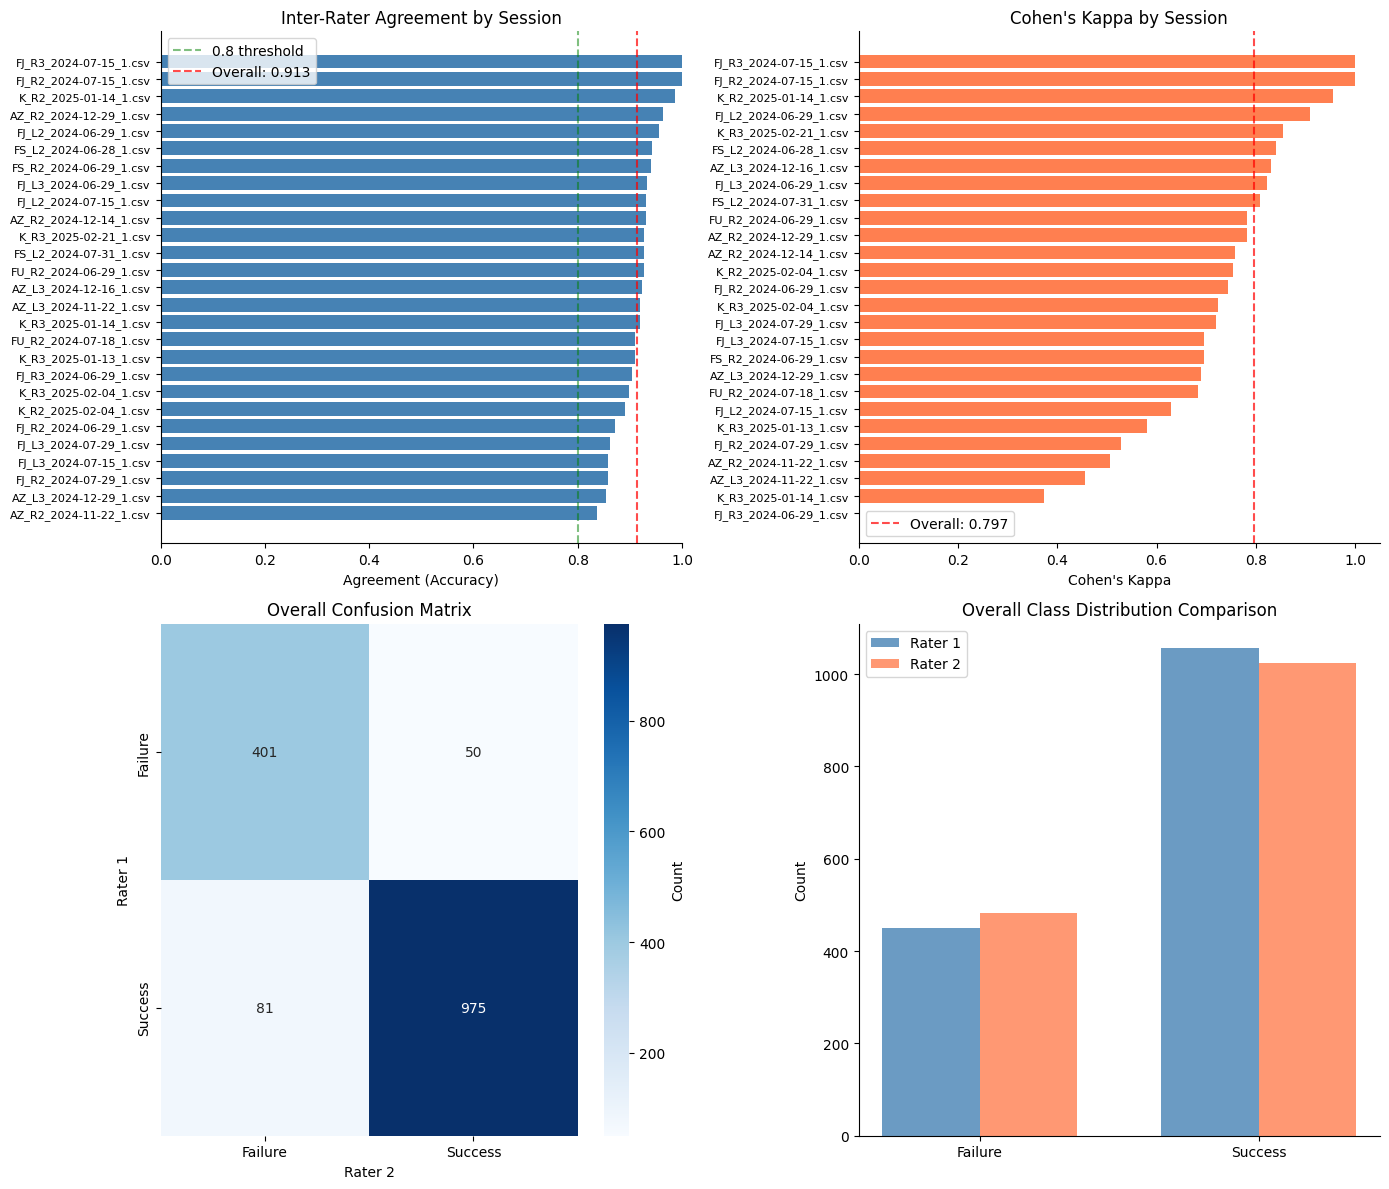


✅ Results saved to 'inter_rater_comparison_by_file.csv'

📈 SUMMARY STATISTICS

Mean accuracy: 0.9177 ± 0.0431
Mean Cohen's Kappa: 0.7082 ± 0.2093
Median accuracy: 0.9231
Median Cohen's Kappa: 0.7442
Min accuracy: 0.8378 (AZ_R2_2024-11-22_1.csv)
Max accuracy: 1.0000 (FJ_R2_2024-07-15_1.csv)


In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def compare_hand_scorers(hand_scored_data, hand_scored_data2, merge_on='trial'):
    """
    Compare two hand-scorers and calculate inter-rater reliability metrics.
    
    Args:
        hand_scored_data: Dictionary of DataFrames from first scorer
        hand_scored_data2: Dictionary of DataFrames from second scorer
        merge_on: Column to merge on (default: 'trial')
    
    Returns:
        Dictionary containing comparison results and metrics
    """
    
    results = []
    all_rater1 = []
    all_rater2 = []
    
    # Find common files
    common_files = set(hand_scored_data.keys()) & set(hand_scored_data2.keys())
    
    print(f"Found {len(common_files)} files scored by both raters\n")
    print("="*80)
    
    for filename in sorted(common_files):
        df1 = hand_scored_data[filename]
        df2 = hand_scored_data2[filename]
        
        print(f"\n📄 {filename}")
        print("-"*80)
        
        # Merge on trial number or index
        if merge_on in df1.columns and merge_on in df2.columns:
            merged = pd.merge(df1[[merge_on, 'outcome']], 
                            df2[[merge_on, 'outcome']], 
                            on=merge_on, 
                            suffixes=('_rater1', '_rater2'))
        else:
            # Merge on index if no trial column
            merged = pd.merge(df1[['outcome']], 
                            df2[['outcome']], 
                            left_index=True, 
                            right_index=True, 
                            suffixes=('_rater1', '_rater2'))
        
        # Remove rows where either rater has NA, ND, or missing values
        valid_mask = (
            merged['outcome_rater1'].notna() & 
            merged['outcome_rater2'].notna() &
            ~merged['outcome_rater1'].isin(['na', 'nd', 'NA', 'ND']) &
            ~merged['outcome_rater2'].isin(['na', 'nd', 'NA', 'ND'])
        )
        
        merged_clean = merged[valid_mask].copy()
        
        if len(merged_clean) == 0:
            print(f"  ⚠️  No valid overlapping scores")
            continue
        
        # Extract ratings
        rater1 = merged_clean['outcome_rater1'].values
        rater2 = merged_clean['outcome_rater2'].values
        
        # Add to overall lists
        all_rater1.extend(rater1)
        all_rater2.extend(rater2)
        
        # Calculate metrics
        accuracy = accuracy_score(rater1, rater2)
        kappa = cohen_kappa_score(rater1, rater2)
        
        # Confusion matrix
        cm = confusion_matrix(rater1, rater2, labels=['f', 's'])
        
        # Agreement counts
        total = len(rater1)
        agreements = (rater1 == rater2).sum()
        disagreements = (rater1 != rater2).sum()
        
        # Class distributions
        rater1_dist = pd.Series(rater1).value_counts()
        rater2_dist = pd.Series(rater2).value_counts()
        
        print(f"  Total valid trials: {total}")
        print(f"  Agreements: {agreements} ({100*agreements/total:.1f}%)")
        print(f"  Disagreements: {disagreements} ({100*disagreements/total:.1f}%)")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Cohen's Kappa: {kappa:.4f}")
        
        print(f"\n  Rater 1 distribution:")
        for label, count in rater1_dist.items():
            print(f"    {label}: {count} ({100*count/total:.1f}%)")
        
        print(f"  Rater 2 distribution:")
        for label, count in rater2_dist.items():
            print(f"    {label}: {count} ({100*count/total:.1f}%)")
        
        print(f"\n  Confusion Matrix (Rater1=rows, Rater2=cols):")
        print(f"           f    s")
        print(f"    f    {cm[0,0]:3d}  {cm[0,1]:3d}")
        print(f"    s    {cm[1,0]:3d}  {cm[1,1]:3d}")
        
        # Store results
        results.append({
            'filename': filename,
            'total_trials': total,
            'agreements': agreements,
            'disagreements': disagreements,
            'accuracy': accuracy,
            'cohen_kappa': kappa,
            'rater1_f': rater1_dist.get('f', 0),
            'rater1_s': rater1_dist.get('s', 0),
            'rater2_f': rater2_dist.get('f', 0),
            'rater2_s': rater2_dist.get('s', 0),
            'cm_ff': cm[0,0],
            'cm_fs': cm[0,1],
            'cm_sf': cm[1,0],
            'cm_ss': cm[1,1]
        })
    
    # Overall statistics
    print("\n" + "="*80)
    print("📊 OVERALL INTER-RATER RELIABILITY")
    print("="*80)
    
    all_rater1 = np.array(all_rater1)
    all_rater2 = np.array(all_rater2)
    
    overall_accuracy = accuracy_score(all_rater1, all_rater2)
    overall_kappa = cohen_kappa_score(all_rater1, all_rater2)
    overall_cm = confusion_matrix(all_rater1, all_rater2, labels=['f', 's'])
    
    total_all = len(all_rater1)
    agreements_all = (all_rater1 == all_rater2).sum()
    disagreements_all = (all_rater1 != all_rater2).sum()
    
    print(f"\nTotal trials scored by both: {total_all}")
    print(f"Total agreements: {agreements_all} ({100*agreements_all/total_all:.1f}%)")
    print(f"Total disagreements: {disagreements_all} ({100*disagreements_all/total_all:.1f}%)")
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
    print(f"Overall Cohen's Kappa: {overall_kappa:.4f}")
    
    print(f"\nKappa Interpretation:")
    if overall_kappa < 0:
        print("  ⚠️  Poor agreement (worse than chance)")
    elif overall_kappa < 0.20:
        print("  ⚠️  Slight agreement")
    elif overall_kappa < 0.40:
        print("  ⚠️  Fair agreement")
    elif overall_kappa < 0.60:
        print("  ✓  Moderate agreement")
    elif overall_kappa < 0.80:
        print("  ✓✓ Substantial agreement")
    else:
        print("  ✓✓✓ Almost perfect agreement")
    
    print(f"\nOverall Confusion Matrix (Rater1=rows, Rater2=cols):")
    print(f"           f      s")
    print(f"    f    {overall_cm[0,0]:4d}   {overall_cm[0,1]:4d}")
    print(f"    s    {overall_cm[1,0]:4d}   {overall_cm[1,1]:4d}")
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(all_rater1, all_rater2, target_names=['Failure', 'Success']))
    
    return {
        'results_per_file': pd.DataFrame(results),
        'overall_accuracy': overall_accuracy,
        'overall_kappa': overall_kappa,
        'overall_confusion_matrix': overall_cm,
        'all_rater1': all_rater1,
        'all_rater2': all_rater2
    }


def plot_inter_rater_comparison(comparison_results, save_path=None):
    """
    Create visualizations for inter-rater reliability.
    
    Args:
        comparison_results: Output from compare_hand_scorers()
        save_path: Optional path to save the plot
    """
    results_df = comparison_results['results_per_file']
    cm = comparison_results['overall_confusion_matrix']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # 1. Agreement per file
    ax = axes[0, 0]
    results_df_sorted = results_df.sort_values('accuracy', ascending=True)
    ax.barh(range(len(results_df_sorted)), results_df_sorted['accuracy'], color='steelblue')
    ax.set_yticks(range(len(results_df_sorted)))
    ax.set_yticklabels(results_df_sorted['filename'], fontsize=8)
    ax.set_xlabel('Agreement (Accuracy)')
    ax.set_title('Inter-Rater Agreement by Session')
    ax.axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='0.8 threshold')
    ax.axvline(x=comparison_results['overall_accuracy'], color='red', linestyle='--', 
               alpha=0.7, label=f'Overall: {comparison_results["overall_accuracy"]:.3f}')
    ax.legend()
    ax.set_xlim(0, 1)
    sns.despine(ax=ax)
    
    # 2. Cohen's Kappa per file
    ax = axes[0, 1]
    results_df_sorted = results_df.sort_values('cohen_kappa', ascending=True)
    ax.barh(range(len(results_df_sorted)), results_df_sorted['cohen_kappa'], color='coral')
    ax.set_yticks(range(len(results_df_sorted)))
    ax.set_yticklabels(results_df_sorted['filename'], fontsize=8)
    ax.set_xlabel("Cohen's Kappa")
    ax.set_title("Cohen's Kappa by Session")
    ax.axvline(x=comparison_results['overall_kappa'], color='red', linestyle='--', 
               alpha=0.7, label=f'Overall: {comparison_results["overall_kappa"]:.3f}')
    ax.legend()
    sns.despine(ax=ax)
    
    # 3. Confusion matrix heatmap
    ax = axes[1, 0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Failure', 'Success'],
                yticklabels=['Failure', 'Success'],
                cbar_kws={'label': 'Count'})
    ax.set_xlabel('Rater 2')
    ax.set_ylabel('Rater 1')
    ax.set_title('Overall Confusion Matrix')
    
    # 4. Distribution comparison
    ax = axes[1, 1]
    rater1_counts = pd.Series(comparison_results['all_rater1']).value_counts()
    rater2_counts = pd.Series(comparison_results['all_rater2']).value_counts()
    
    x = np.arange(2)
    width = 0.35
    
    ax.bar(x - width/2, [rater1_counts.get('f', 0), rater1_counts.get('s', 0)], 
           width, label='Rater 1', color='steelblue', alpha=0.8)
    ax.bar(x + width/2, [rater2_counts.get('f', 0), rater2_counts.get('s', 0)], 
           width, label='Rater 2', color='coral', alpha=0.8)
    
    ax.set_ylabel('Count')
    ax.set_title('Overall Class Distribution Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(['Failure', 'Success'])
    ax.legend()
    sns.despine(ax=ax)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ Plot saved to {save_path}")
    
    plt.show()


# ============================================================================
# USAGE
# ============================================================================

# Run the comparison
comparison_results = compare_hand_scorers(hand_scored_data, hand_scored_data2, merge_on='trial')

# Create visualizations
plot_inter_rater_comparison(comparison_results, save_path='inter_rater_reliability.png')

# Save results to CSV
comparison_results['results_per_file'].to_csv('inter_rater_comparison_by_file.csv', index=False)
print("\n✅ Results saved to 'inter_rater_comparison_by_file.csv'")

# Print summary statistics
print("\n" + "="*80)
print("📈 SUMMARY STATISTICS")
print("="*80)
results_df = comparison_results['results_per_file']
print(f"\nMean accuracy: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Mean Cohen's Kappa: {results_df['cohen_kappa'].mean():.4f} ± {results_df['cohen_kappa'].std():.4f}")
print(f"Median accuracy: {results_df['accuracy'].median():.4f}")
print(f"Median Cohen's Kappa: {results_df['cohen_kappa'].median():.4f}")
print(f"Min accuracy: {results_df['accuracy'].min():.4f} ({results_df.loc[results_df['accuracy'].idxmin(), 'filename']})")
print(f"Max accuracy: {results_df['accuracy'].max():.4f} ({results_df.loc[results_df['accuracy'].idxmax(), 'filename']})")

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution_comparison(comparison_results, save_path=None):
    """
    Create an enhanced class distribution comparison plot with:
    - Bar plots with error bars
    - Individual session points
    - Lines connecting Rater 1 to Rater 2 for each session
    
    Args:
        comparison_results: Output from compare_hand_scorers()
        save_path: Optional path to save the plot
    """
    results_df = comparison_results['results_per_file']
    
    # Calculate proportions for each session
    results_df['prop_f_rater1'] = results_df['rater1_f'] / (results_df['rater1_f'] + results_df['rater1_s'])
    results_df['prop_s_rater1'] = results_df['rater1_s'] / (results_df['rater1_f'] + results_df['rater1_s'])
    results_df['prop_f_rater2'] = results_df['rater2_f'] / (results_df['rater2_f'] + results_df['rater2_s'])
    results_df['prop_s_rater2'] = results_df['rater2_s'] / (results_df['rater2_f'] + results_df['rater2_s'])
    
    # Calculate means and SEMs
    mean_f_r1 = results_df['prop_f_rater1'].mean()
    mean_s_r1 = results_df['prop_s_rater1'].mean()
    mean_f_r2 = results_df['prop_f_rater2'].mean()
    mean_s_r2 = results_df['prop_s_rater2'].mean()
    
    sem_f_r1 = results_df['prop_f_rater1'].sem()
    sem_s_r1 = results_df['prop_s_rater1'].sem()
    sem_f_r2 = results_df['prop_f_rater2'].sem()
    sem_s_r2 = results_df['prop_s_rater2'].sem()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(5, 7))
    
    # Set up positions
    x_positions = np.array([0, 1])  # Failure and Success
    width = 0.35
    
    # Plot bars with error bars
    bars1 = ax.bar(x_positions - width/2, 
                   [mean_f_r1, mean_s_r1], 
                   width, 
                   yerr=[sem_f_r1, sem_s_r1],
                   label='Rater 1', 
                   color='#3498db', 
                   alpha=0.7,
                   capsize=12,
                   edgecolor='black',
                   linewidth=1.0)
    
    bars2 = ax.bar(x_positions + width/2, 
                   [mean_f_r2, mean_s_r2], 
                   width, 
                   yerr=[sem_f_r2, sem_s_r2],
                   label='Rater 2', 
                   color='#e74c3c', 
                   alpha=0.7,
                   capsize=12,
                   edgecolor='black',
                   linewidth=1.0)
    
    # Plot individual session points and connecting lines
    for idx, row in results_df.iterrows():
        # Failure (left side)
        x_f_r1 = 0 - width/2
        x_f_r2 = 0 + width/2
        y_f_r1 = row['prop_f_rater1']
        y_f_r2 = row['prop_f_rater2']
        
        # Plot points
        ax.scatter([x_f_r1], [y_f_r1], color='#2980b9', s=40, alpha=0.6, zorder=3, edgecolor='black', linewidth=0.5)
        ax.scatter([x_f_r2], [y_f_r2], color='#c0392b', s=40, alpha=0.6, zorder=3, edgecolor='black', linewidth=0.5)
        
        # Connect with line
        ax.plot([x_f_r1, x_f_r2], [y_f_r1, y_f_r2], 
                color='gray', alpha=0.3, linewidth=1, zorder=2)
        
        # Success (right side)
        x_s_r1 = 1 - width/2
        x_s_r2 = 1 + width/2
        y_s_r1 = row['prop_s_rater1']
        y_s_r2 = row['prop_s_rater2']
        
        # Plot points
        ax.scatter([x_s_r1], [y_s_r1], color='#2980b9', s=40, alpha=0.6, zorder=3, edgecolor='black', linewidth=0.5)
        ax.scatter([x_s_r2], [y_s_r2], color='#c0392b', s=40, alpha=0.6, zorder=3, edgecolor='black', linewidth=0.5)
        
        # Connect with line
        ax.plot([x_s_r1, x_s_r2], [y_s_r1, y_s_r2], 
                color='gray', alpha=0.3, linewidth=1, zorder=2)
    
    # Styling
    ax.set_ylabel('Proportion', fontsize=14, fontweight='bold')
    ax.set_xlabel('Trial Outcome', fontsize=14, fontweight='bold')
    ax.set_title('Class Distribution Comparison Between Raters', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(['Failure', 'Success'], fontsize=12)
    ax.set_ylim(0, 1.05)
    ax.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Add text with overall stats
    textstr = f'Cohen\'s κ: {comparison_results["overall_kappa"]:.3f}'
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    sns.despine(ax=ax)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("Class Distribution Summary")
    print("="*60)
    print(f"\nFailure Proportion:")
    print(f"  Rater 1: {mean_f_r1:.3f} ± {sem_f_r1:.3f}")
    print(f"  Rater 2: {mean_f_r2:.3f} ± {sem_f_r2:.3f}")
    print(f"  Difference: {abs(mean_f_r1 - mean_f_r2):.3f}")
    
    print(f"\nSuccess Proportion:")
    print(f"  Rater 1: {mean_s_r1:.3f} ± {sem_s_r1:.3f}")
    print(f"  Rater 2: {mean_s_r2:.3f} ± {sem_s_r2:.3f}")
    print(f"  Difference: {abs(mean_s_r1 - mean_s_r2):.3f}")


# Alternative version: Counts instead of proportions
def plot_class_distribution_counts(comparison_results, save_path=None):
    """
    Same plot but with raw counts instead of proportions.
    """
    results_df = comparison_results['results_per_file']
    
    # Calculate means and SEMs for counts
    mean_f_r1 = results_df['rater1_f'].mean()
    mean_s_r1 = results_df['rater1_s'].mean()
    mean_f_r2 = results_df['rater2_f'].mean()
    mean_s_r2 = results_df['rater2_s'].mean()
    
    sem_f_r1 = results_df['rater1_f'].sem()
    sem_s_r1 = results_df['rater1_s'].sem()
    sem_f_r2 = results_df['rater2_f'].sem()
    sem_s_r2 = results_df['rater2_s'].sem()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Set up positions
    x_positions = np.array([0, 1])
    width = 0.35
    
    # Plot bars with error bars
    bars1 = ax.bar(x_positions - width/2, 
                   [mean_f_r1, mean_s_r1], 
                   width, 
                   yerr=[sem_f_r1, sem_s_r1],
                   label='Rater 1', 
                   color='#3498db', 
                   alpha=0.7,
                   capsize=12,
                   edgecolor='black',
                   linewidth=1.0)
    
    bars2 = ax.bar(x_positions + width/2, 
                   [mean_f_r2, mean_s_r2], 
                   width, 
                   yerr=[sem_f_r2, sem_s_r2],
                   label='Rater 2', 
                   color='#e74c3c', 
                   alpha=0.7,
                   capsize=12,
                   edgecolor='black',
                   linewidth=1.0)
    
    # Plot individual session points and connecting lines
    for idx, row in results_df.iterrows():
        # Failure
        x_f_r1 = 0 - width/2
        x_f_r2 = 0 + width/2
        y_f_r1 = row['rater1_f']
        y_f_r2 = row['rater2_f']

        ax.scatter([x_f_r1], [y_f_r1],  s=40, color='black', zorder=3, edgecolor='black', linewidth=0.5)
        ax.scatter([x_f_r2], [y_f_r2], color='black', s=40, zorder=3, edgecolor='black', linewidth=0.5)
        ax.plot([x_f_r1, x_f_r2], [y_f_r1, y_f_r2], color='gray', alpha=0.3, linewidth=1, zorder=2)
        
        # Success
        x_s_r1 = 1 - width/2
        x_s_r2 = 1 + width/2
        y_s_r1 = row['rater1_s']
        y_s_r2 = row['rater2_s']
        
        ax.scatter([x_s_r1], [y_s_r1], color='#2980b9', s=40,  zorder=3, edgecolor='black', linewidth=0.5)
        ax.scatter([x_s_r2], [y_s_r2], color='#c0392b', s=40, zorder=3, edgecolor='black', linewidth=0.5)
        ax.plot([x_s_r1, x_s_r2], [y_s_r1, y_s_r2], color='gray', alpha=0.7, linewidth=1, zorder=2)
    
    # Styling
    ax.set_ylabel('Count per Session', fontsize=14, fontweight='bold')
    ax.set_xlabel('Trial Outcome', fontsize=14, fontweight='bold')
    ax.set_title('Class Distribution Comparison Between Raters', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(['Failure', 'Success'], fontsize=12)
    ax.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Add text with overall stats
    textstr = f'Cohen\'s κ: {comparison_results["overall_kappa"]:.3f}'
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    sns.despine(ax=ax)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()

✅ Plot saved to class_distribution_proportions.png


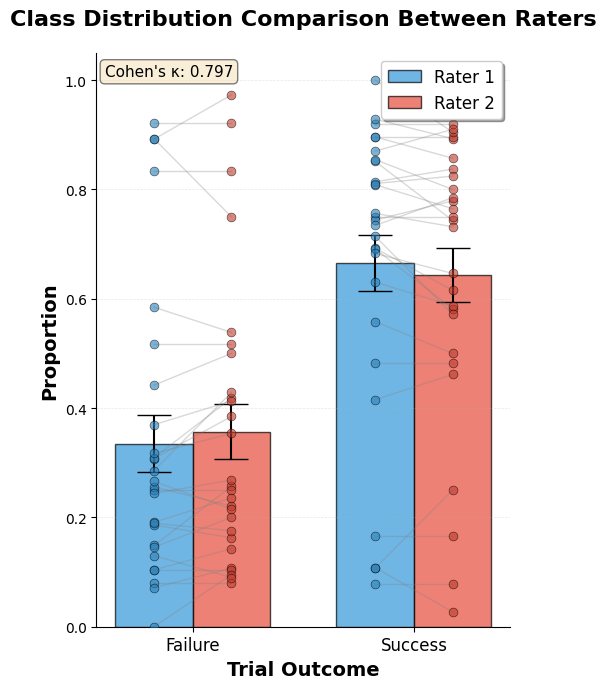


Class Distribution Summary

Failure Proportion:
  Rater 1: 0.335 ± 0.052
  Rater 2: 0.357 ± 0.050
  Difference: 0.022

Success Proportion:
  Rater 1: 0.665 ± 0.052
  Rater 2: 0.643 ± 0.050
  Difference: 0.022


In [40]:
plot_class_distribution_comparison(comparison_results, 
                                   save_path='class_distribution_proportions.png')


📊 SESSION-LEVEL COHEN'S KAPPA ANALYSIS

Number of sessions: 27

Kappa Statistics:
  Mean:   0.708 ± 0.040 (SEM)
  Median: 0.744
  Std:    0.205
  Range:  [0.000, 1.000]
  IQR:    [0.656, 0.827]

Best agreement:
  FJ_R2_2024-07-15_1.csv
  κ = 1.000
  Accuracy: 100.0%
  Disagreements: 0/38

Worst agreement:
  FJ_R3_2024-06-29_1.csv
  κ = 0.000
  Accuracy: 90.5%
  Disagreements: 4/42

Interpretation (Landis & Koch, 1977):
  ✓✓ Substantial agreement

✅ Plot saved to session_level_kappa_analysis.png


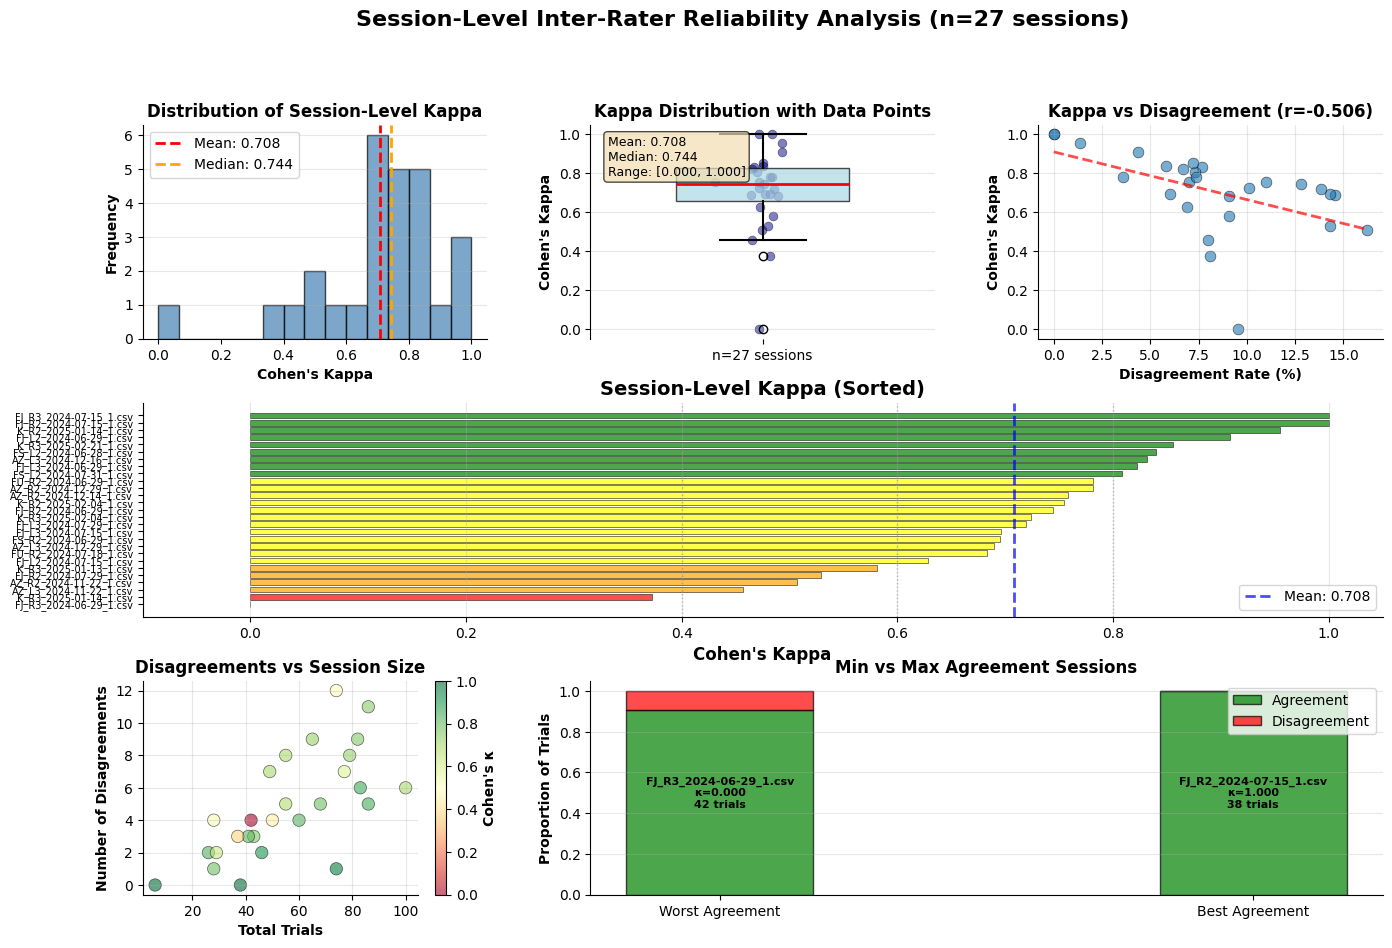


✅ Summary table saved to session_kappa_summary.csv

Top 5 Sessions (Best Agreement):
              filename  total_trials  agreements  disagreements accuracy cohen_kappa disagreement_rate
FJ_R2_2024-07-15_1.csv            38          38              0    1.000       1.000             0.000
FJ_R3_2024-07-15_1.csv             6           6              0    1.000       1.000             0.000
 K_R2_2025-01-14_1.csv            74          73              1    0.986       0.955             0.014
FJ_L2_2024-06-29_1.csv            46          44              2    0.957       0.909             0.043
 K_R3_2025-02-21_1.csv            83          77              6    0.928       0.855             0.072

Bottom 5 Sessions (Worst Agreement):
              filename  total_trials  agreements  disagreements accuracy cohen_kappa disagreement_rate
FJ_R2_2024-07-29_1.csv            28          24              4    0.857       0.529             0.143
AZ_R2_2024-11-22_1.csv            74          62    

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_session_level_kappa(comparison_results, save_path=None):
    """
    Analyze and visualize session-level Cohen's Kappa with range information.
    
    Args:
        comparison_results: Output from compare_hand_scorers()
        save_path: Optional path to save the plot
    """
    results_df = comparison_results['results_per_file']
    
    # Calculate statistics
    kappas = results_df['cohen_kappa'].values
    mean_kappa = np.mean(kappas)
    median_kappa = np.median(kappas)
    std_kappa = np.std(kappas)
    sem_kappa = stats.sem(kappas)
    min_kappa = np.min(kappas)
    max_kappa = np.max(kappas)
    
    n_sessions = len(kappas)
    
    # Calculate disagreement rate per session
    results_df['disagreement_rate'] = results_df['disagreements'] / results_df['total_trials']
    
    # Print summary statistics
    print("\n" + "="*80)
    print("📊 SESSION-LEVEL COHEN'S KAPPA ANALYSIS")
    print("="*80)
    print(f"\nNumber of sessions: {n_sessions}")
    print(f"\nKappa Statistics:")
    print(f"  Mean:   {mean_kappa:.3f} ± {sem_kappa:.3f} (SEM)")
    print(f"  Median: {median_kappa:.3f}")
    print(f"  Std:    {std_kappa:.3f}")
    print(f"  Range:  [{min_kappa:.3f}, {max_kappa:.3f}]")
    print(f"  IQR:    [{np.percentile(kappas, 25):.3f}, {np.percentile(kappas, 75):.3f}]")
    
    # Find best and worst sessions
    best_idx = results_df['cohen_kappa'].idxmax()
    worst_idx = results_df['cohen_kappa'].idxmin()
    
    print(f"\nBest agreement:")
    print(f"  {results_df.loc[best_idx, 'filename']}")
    print(f"  κ = {results_df.loc[best_idx, 'cohen_kappa']:.3f}")
    print(f"  Accuracy: {results_df.loc[best_idx, 'accuracy']:.1%}")
    print(f"  Disagreements: {results_df.loc[best_idx, 'disagreements']}/{results_df.loc[best_idx, 'total_trials']}")
    
    print(f"\nWorst agreement:")
    print(f"  {results_df.loc[worst_idx, 'filename']}")
    print(f"  κ = {results_df.loc[worst_idx, 'cohen_kappa']:.3f}")
    print(f"  Accuracy: {results_df.loc[worst_idx, 'accuracy']:.1%}")
    print(f"  Disagreements: {results_df.loc[worst_idx, 'disagreements']}/{results_df.loc[worst_idx, 'total_trials']}")
    
    # Interpretation
    print(f"\nInterpretation (Landis & Koch, 1977):")
    if mean_kappa < 0:
        print("  ⚠️  Poor agreement (worse than chance)")
    elif mean_kappa < 0.20:
        print("  ⚠️  Slight agreement")
    elif mean_kappa < 0.40:
        print("  ⚠️  Fair agreement")
    elif mean_kappa < 0.60:
        print("  ✓  Moderate agreement")
    elif mean_kappa < 0.80:
        print("  ✓✓ Substantial agreement")
    else:
        print("  ✓✓✓ Almost perfect agreement")
    
    print("="*80 + "\n")
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Histogram of kappa values
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(kappas, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axvline(mean_kappa, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_kappa:.3f}')
    ax1.axvline(median_kappa, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_kappa:.3f}')
    ax1.set_xlabel("Cohen's Kappa", fontweight='bold')
    ax1.set_ylabel('Frequency', fontweight='bold')
    ax1.set_title('Distribution of Session-Level Kappa', fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    sns.despine(ax=ax1)
    
    # 2. Box plot with individual points
    ax2 = fig.add_subplot(gs[0, 1])
    bp = ax2.boxplot([kappas], widths=0.5, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(linewidth=1.5),
                      capprops=dict(linewidth=1.5))
    
    # Add individual points
    x_jitter = np.random.normal(1, 0.04, size=len(kappas))
    ax2.scatter(x_jitter, kappas, alpha=0.5, s=40, color='darkblue', edgecolor='black', linewidth=0.5)
    
    ax2.set_ylabel("Cohen's Kappa", fontweight='bold')
    ax2.set_title('Kappa Distribution with Data Points', fontweight='bold')
    ax2.set_xticks([1])
    ax2.set_xticklabels([f'n={n_sessions} sessions'])
    ax2.grid(axis='y', alpha=0.3)
    sns.despine(ax=ax2, bottom=True)
    
    # Add text with statistics
    stats_text = f"Mean: {mean_kappa:.3f}\nMedian: {median_kappa:.3f}\nRange: [{min_kappa:.3f}, {max_kappa:.3f}]"
    ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, 
             verticalalignment='top', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # 3. Kappa vs Disagreement Rate
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.scatter(results_df['disagreement_rate'] * 100, results_df['cohen_kappa'], 
                s=60, alpha=0.6, edgecolor='black', linewidth=0.5)
    
    # Add correlation line
    z = np.polyfit(results_df['disagreement_rate'] * 100, results_df['cohen_kappa'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(results_df['disagreement_rate'].min() * 100, 
                         results_df['disagreement_rate'].max() * 100, 100)
    ax3.plot(x_line, p(x_line), "r--", alpha=0.7, linewidth=2)
    
    # Calculate correlation
    corr = np.corrcoef(results_df['disagreement_rate'], results_df['cohen_kappa'])[0, 1]
    
    ax3.set_xlabel('Disagreement Rate (%)', fontweight='bold')
    ax3.set_ylabel("Cohen's Kappa", fontweight='bold')
    ax3.set_title(f'Kappa vs Disagreement (r={corr:.3f})', fontweight='bold')
    ax3.grid(alpha=0.3)
    sns.despine(ax=ax3)
    
    # 4. Kappa by session (sorted)
    ax4 = fig.add_subplot(gs[1, :])
    results_sorted = results_df.sort_values('cohen_kappa', ascending=True)
    
    colors = ['red' if k < 0.4 else 'orange' if k < 0.6 else 'yellow' if k < 0.8 else 'green' 
              for k in results_sorted['cohen_kappa']]
    
    bars = ax4.barh(range(len(results_sorted)), results_sorted['cohen_kappa'], color=colors, 
                    edgecolor='black', linewidth=0.5, alpha=0.7)
    
    ax4.set_yticks(range(len(results_sorted)))
    ax4.set_yticklabels(results_sorted['filename'], fontsize=7)
    ax4.set_xlabel("Cohen's Kappa", fontweight='bold', fontsize=12)
    ax4.set_title('Session-Level Kappa (Sorted)', fontweight='bold', fontsize=14)
    ax4.axvline(mean_kappa, color='blue', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {mean_kappa:.3f}')
    ax4.axvline(0.4, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    ax4.axvline(0.6, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    ax4.axvline(0.8, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    ax4.legend(loc='lower right')
    ax4.set_xlim(-0.1, 1.05)
    ax4.grid(axis='x', alpha=0.3)
    sns.despine(ax=ax4)
    
    # 5. Disagreement patterns
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.scatter(results_df['total_trials'], results_df['disagreements'], 
                s=80, alpha=0.6, edgecolor='black', linewidth=0.5, c=results_df['cohen_kappa'],
                cmap='RdYlGn', vmin=0, vmax=1)
    
    ax5.set_xlabel('Total Trials', fontweight='bold')
    ax5.set_ylabel('Number of Disagreements', fontweight='bold')
    ax5.set_title('Disagreements vs Session Size', fontweight='bold')
    ax5.grid(alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(ax5.collections[0], ax=ax5)
    cbar.set_label("Cohen's κ", fontweight='bold')
    
    sns.despine(ax=ax5)
    
    # 6. Min and Max disagreement sessions
    ax6 = fig.add_subplot(gs[2, 1:])
    
    # Get sessions with min and max kappa
    sessions_to_show = [worst_idx, best_idx]
    session_labels = ['Worst Agreement', 'Best Agreement']
    
    x_pos = np.arange(2)
    width = 0.35
    
    # Extract data for these sessions
    for i, (idx, label) in enumerate(zip(sessions_to_show, session_labels)):
        row = results_df.loc[idx]
        
        # Calculate proportions
        prop_agree = row['agreements'] / row['total_trials']
        prop_disagree = row['disagreements'] / row['total_trials']
        
        # Stack bars
        ax6.bar(x_pos[i], prop_agree, width, label='Agreement' if i == 0 else '', 
                color='green', alpha=0.7, edgecolor='black')
        ax6.bar(x_pos[i], prop_disagree, width, bottom=prop_agree, 
                label='Disagreement' if i == 0 else '', color='red', alpha=0.7, edgecolor='black')
        
        # Add text
        ax6.text(x_pos[i], 0.5, f"{row['filename']}\nκ={row['cohen_kappa']:.3f}\n{row['total_trials']} trials",
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    ax6.set_ylabel('Proportion of Trials', fontweight='bold')
    ax6.set_title('Min vs Max Agreement Sessions', fontweight='bold')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(session_labels)
    ax6.set_ylim(0, 1.05)
    ax6.legend(loc='upper right')
    ax6.grid(axis='y', alpha=0.3)
    sns.despine(ax=ax6)
    
    plt.suptitle(f'Session-Level Inter-Rater Reliability Analysis (n={n_sessions} sessions)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()
    
    return {
        'mean_kappa': mean_kappa,
        'median_kappa': median_kappa,
        'std_kappa': std_kappa,
        'sem_kappa': sem_kappa,
        'min_kappa': min_kappa,
        'max_kappa': max_kappa,
        'n_sessions': n_sessions
    }


def create_kappa_summary_table(comparison_results, save_path=None):
    """
    Create a summary table of kappa statistics by session.
    """
    results_df = comparison_results['results_per_file']
    
    # Select relevant columns
    summary = results_df[[
        'filename', 'total_trials', 'agreements', 'disagreements', 
        'accuracy', 'cohen_kappa'
    ]].copy()
    
    # Add disagreement rate
    summary['disagreement_rate'] = summary['disagreements'] / summary['total_trials']
    
    # Sort by kappa
    summary = summary.sort_values('cohen_kappa', ascending=False)
    
    # Format columns
    summary['accuracy'] = summary['accuracy'].apply(lambda x: f"{x:.3f}")
    summary['cohen_kappa'] = summary['cohen_kappa'].apply(lambda x: f"{x:.3f}")
    summary['disagreement_rate'] = summary['disagreement_rate'].apply(lambda x: f"{x:.3f}")
    
    if save_path:
        summary.to_csv(save_path, index=False)
        print(f"\n✅ Summary table saved to {save_path}")
    
    print("\n" + "="*80)
    print("Top 5 Sessions (Best Agreement):")
    print("="*80)
    print(summary.head(5).to_string(index=False))
    
    print("\n" + "="*80)
    print("Bottom 5 Sessions (Worst Agreement):")
    print("="*80)
    print(summary.tail(5).to_string(index=False))
    
    return summary


# ============================================================================
# USAGE
# ============================================================================

# Run the analysis
kappa_stats = analyze_session_level_kappa(
    comparison_results, 
    save_path='session_level_kappa_analysis.png'
)

# Create summary table
summary_table = create_kappa_summary_table(
    comparison_results,
    save_path='session_kappa_summary.csv'
)

# Print formatted results for paper
print("\n" + "="*80)
print("📝 FORMATTED RESULTS FOR PAPER")
print("="*80)
print(f"\nInter-rater reliability was assessed at the session level.")
print(f"Cohen's kappa showed substantial agreement across {kappa_stats['n_sessions']} sessions:")
print(f"  Mean κ = {kappa_stats['mean_kappa']:.3f} ± {kappa_stats['sem_kappa']:.3f} (SEM)")
print(f"  Median κ = {kappa_stats['median_kappa']:.3f}")
print(f"  Range: [{kappa_stats['min_kappa']:.3f}, {kappa_stats['max_kappa']:.3f}]")
print("\nThis indicates substantial to almost perfect agreement between raters")
print("(Landis & Koch, 1977), demonstrating reliable behavioral scoring.")
print("="*80)


📊 DISTRIBUTION OF SESSIONS BY KAPPA AGREEMENT LEVEL
  Poor (< 0.00)                 :  0 sessions (  0.0%)
⚠️ Slight (0.00-0.20)            :  1 sessions (  3.7%)
⚠️ Fair (0.20-0.40)              :  1 sessions (  3.7%)
✓ Moderate (0.40-0.60)          :  4 sessions ( 14.8%)
✓ Substantial (0.60-0.80)       : 12 sessions ( 44.4%)
✓ Almost Perfect (0.80-1.00)    :  9 sessions ( 33.3%)


⚠️  SESSIONS WITH WEAK TO MODERATE AGREEMENT (κ < 0.60):
Total: 6 out of 27 sessions (22.2%)

FJ_R3_2024-06-29_1.csv
  κ = 0.000 (Slight (0.00-0.20))
  Accuracy: 90.5% (38/42 agreed)
  Disagreements: 4 trials (9.5%)
  Class distribution:
    Rater 1: 0 failures, 42 successes
    Rater 2: 4 failures, 38 successes

K_R3_2025-01-14_1.csv
  κ = 0.373 (Fair (0.20-0.40))
  Accuracy: 91.9% (34/37 agreed)
  Disagreements: 3 trials (8.1%)
  Class distribution:
    Rater 1: 33 failures, 4 successes
    Rater 2: 36 failures, 1 successes

AZ_L3_2024-11-22_1.csv
  κ = 0.457 (Moderate (0.40-0.60))
  Accuracy: 92.0% (46/

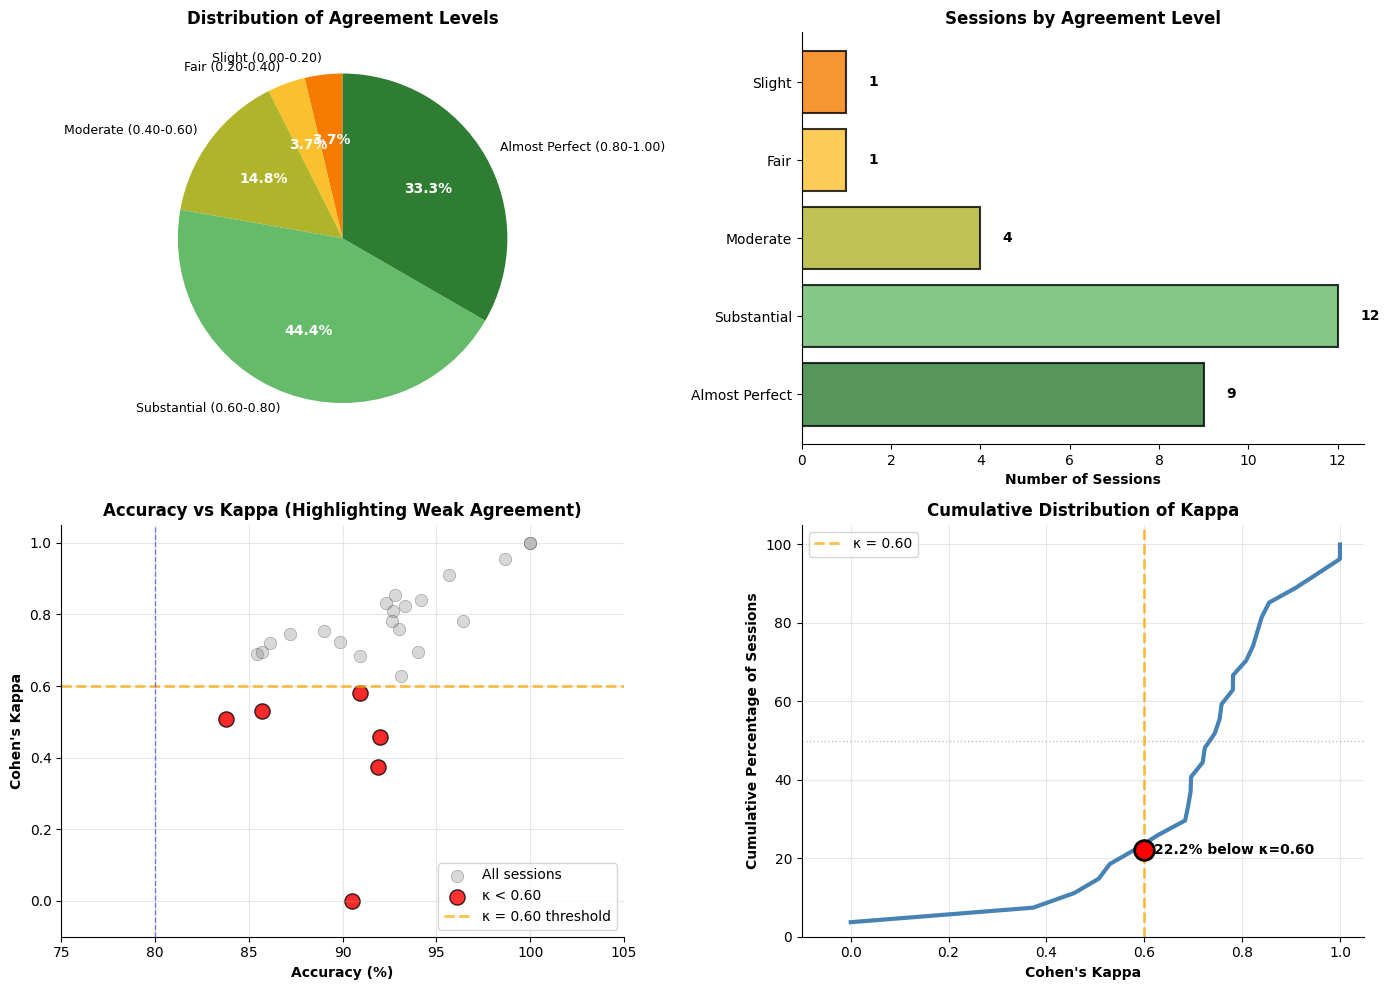


🎯 ASSESSMENT OF INTER-RATER RELIABILITY

⚠️  MODERATE CONCERN: 22.2% of sessions have κ < 0.60
This is borderline acceptable but could be improved.

Recommendations:
  1. Investigate the weak-agreement sessions
  2. Check if they share common characteristics
  3. Consider additional rater training
  4. Report as 'moderate to substantial' agreement


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def categorize_kappa_agreement(comparison_results, save_path=None):
    """
    Categorize sessions by kappa agreement levels and analyze distribution.
    """
    results_df = comparison_results['results_per_file']
    
    # Define kappa categories (Landis & Koch, 1977)
    def categorize_kappa(k):
        if k < 0:
            return 'Poor (< 0.00)'
        elif k < 0.20:
            return 'Slight (0.00-0.20)'
        elif k < 0.40:
            return 'Fair (0.20-0.40)'
        elif k < 0.60:
            return 'Moderate (0.40-0.60)'
        elif k < 0.80:
            return 'Substantial (0.60-0.80)'
        else:
            return 'Almost Perfect (0.80-1.00)'
    
    results_df['kappa_category'] = results_df['cohen_kappa'].apply(categorize_kappa)
    
    # Count sessions in each category
    category_counts = results_df['kappa_category'].value_counts()
    
    print("\n" + "="*80)
    print("📊 DISTRIBUTION OF SESSIONS BY KAPPA AGREEMENT LEVEL")
    print("="*80)
    
    categories_order = [
        'Poor (< 0.00)',
        'Slight (0.00-0.20)', 
        'Fair (0.20-0.40)',
        'Moderate (0.40-0.60)',
        'Substantial (0.60-0.80)',
        'Almost Perfect (0.80-1.00)'
    ]
    
    total = len(results_df)
    
    for cat in categories_order:
        count = category_counts.get(cat, 0)
        pct = 100 * count / total
        status = "⚠️ " if count > 0 and cat in ['Poor (< 0.00)', 'Slight (0.00-0.20)', 'Fair (0.20-0.40)'] else "✓ " if count > 0 else "  "
        print(f"{status}{cat:30s}: {count:2d} sessions ({pct:5.1f}%)")
    
    print(f"\n{'='*80}")
    
    # Problematic sessions (κ < 0.60)
    weak_agreement = results_df[results_df['cohen_kappa'] < 0.60].copy()
    moderate_to_weak = results_df[results_df['cohen_kappa'] < 0.80].copy()
    
    print(f"\n⚠️  SESSIONS WITH WEAK TO MODERATE AGREEMENT (κ < 0.60):")
    print(f"Total: {len(weak_agreement)} out of {total} sessions ({100*len(weak_agreement)/total:.1f}%)")
    print("="*80)
    
    if len(weak_agreement) > 0:
        weak_sorted = weak_agreement.sort_values('cohen_kappa')
        for idx, row in weak_sorted.iterrows():
            print(f"\n{row['filename']}")
            print(f"  κ = {row['cohen_kappa']:.3f} ({row['kappa_category']})")
            print(f"  Accuracy: {row['accuracy']:.1%} ({row['agreements']}/{row['total_trials']} agreed)")
            print(f"  Disagreements: {row['disagreements']} trials ({100*row['disagreements']/row['total_trials']:.1f}%)")
            print(f"  Class distribution:")
            print(f"    Rater 1: {row['rater1_f']} failures, {row['rater1_s']} successes")
            print(f"    Rater 2: {row['rater2_f']} failures, {row['rater2_s']} successes")
    
    # Summary statistics
    print(f"\n{'='*80}")
    print("📈 SUMMARY STATISTICS BY AGREEMENT LEVEL")
    print("="*80)
    
    strong_agreement = results_df[results_df['cohen_kappa'] >= 0.60]
    
    print(f"\nStrong Agreement (κ ≥ 0.60): {len(strong_agreement)} sessions ({100*len(strong_agreement)/total:.1f}%)")
    if len(strong_agreement) > 0:
        print(f"  Mean κ: {strong_agreement['cohen_kappa'].mean():.3f} ± {strong_agreement['cohen_kappa'].sem():.3f}")
        print(f"  Mean accuracy: {strong_agreement['accuracy'].mean():.1%}")
    
    print(f"\nWeak Agreement (κ < 0.60): {len(weak_agreement)} sessions ({100*len(weak_agreement)/total:.1f}%)")
    if len(weak_agreement) > 0:
        print(f"  Mean κ: {weak_agreement['cohen_kappa'].mean():.3f} ± {weak_agreement['cohen_kappa'].sem():.3f}")
        print(f"  Mean accuracy: {weak_agreement['accuracy'].mean():.1%}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Pie chart of categories
    ax = axes[0, 0]
    colors_map = {
        'Poor (< 0.00)': '#d32f2f',
        'Slight (0.00-0.20)': '#f57c00',
        'Fair (0.20-0.40)': '#fbc02d',
        'Moderate (0.40-0.60)': '#afb42b',
        'Substantial (0.60-0.80)': '#66bb6a',
        'Almost Perfect (0.80-1.00)': '#2e7d32'
    }
    
    present_categories = [cat for cat in categories_order if category_counts.get(cat, 0) > 0]
    counts = [category_counts[cat] for cat in present_categories]
    colors = [colors_map[cat] for cat in present_categories]
    
    wedges, texts, autotexts = ax.pie(counts, labels=present_categories, autopct='%1.1f%%',
                                        colors=colors, startangle=90)
    for text in texts:
        text.set_fontsize(9)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax.set_title('Distribution of Agreement Levels', fontweight='bold', fontsize=12)
    
    # 2. Bar chart showing problem
    ax = axes[0, 1]
    categories_present = []
    counts_present = []
    colors_present = []
    
    for cat in categories_order:
        if category_counts.get(cat, 0) > 0:
            categories_present.append(cat.split('(')[0].strip())
            counts_present.append(category_counts[cat])
            colors_present.append(colors_map[cat])
    
    bars = ax.barh(categories_present, counts_present, color=colors_present, 
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    
    ax.set_xlabel('Number of Sessions', fontweight='bold')
    ax.set_title('Sessions by Agreement Level', fontweight='bold', fontsize=12)
    ax.invert_yaxis()
    
    # Add counts on bars
    for i, (bar, count) in enumerate(zip(bars, counts_present)):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{count}', va='center', fontweight='bold')
    
    sns.despine(ax=ax)
    
    # 3. Accuracy vs Kappa for weak agreement sessions
    ax = axes[1, 0]
    
    # All sessions
    ax.scatter(results_df['accuracy']*100, results_df['cohen_kappa'], 
               s=80, alpha=0.3, color='gray', label='All sessions', edgecolor='black', linewidth=0.5)
    
    # Highlight weak agreement
    if len(weak_agreement) > 0:
        ax.scatter(weak_agreement['accuracy']*100, weak_agreement['cohen_kappa'], 
                   s=120, alpha=0.8, color='red', label='κ < 0.60', edgecolor='black', linewidth=1)
    
    ax.axhline(y=0.60, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='κ = 0.60 threshold')
    ax.axvline(x=80, color='blue', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('Accuracy (%)', fontweight='bold')
    ax.set_ylabel("Cohen's Kappa", fontweight='bold')
    ax.set_title('Accuracy vs Kappa (Highlighting Weak Agreement)', fontweight='bold', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlim(75, 105)
    ax.set_ylim(-0.1, 1.05)
    sns.despine(ax=ax)
    
    # 4. Cumulative distribution
    ax = axes[1, 1]
    
    kappas_sorted = np.sort(results_df['cohen_kappa'].values)
    cumulative = np.arange(1, len(kappas_sorted) + 1) / len(kappas_sorted) * 100
    
    ax.plot(kappas_sorted, cumulative, linewidth=3, color='steelblue')
    ax.axvline(x=0.60, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='κ = 0.60')
    ax.axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Find percentage below 0.60
    pct_below_60 = (results_df['cohen_kappa'] < 0.60).sum() / len(results_df) * 100
    ax.scatter([0.60], [pct_below_60], s=200, color='red', zorder=5, edgecolor='black', linewidth=2)
    ax.text(0.62, pct_below_60, f'{pct_below_60:.1f}% below κ=0.60', 
            fontweight='bold', fontsize=10, va='center')
    
    ax.set_xlabel("Cohen's Kappa", fontweight='bold')
    ax.set_ylabel('Cumulative Percentage of Sessions', fontweight='bold')
    ax.set_title('Cumulative Distribution of Kappa', fontweight='bold', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlim(-0.1, 1.05)
    ax.set_ylim(0, 105)
    sns.despine(ax=ax)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ Plot saved to {save_path}")
    
    plt.show()
    
    return {
        'total_sessions': total,
        'weak_count': len(weak_agreement),
        'weak_percentage': 100 * len(weak_agreement) / total,
        'category_counts': category_counts,
        'weak_sessions': weak_agreement
    }


# ============================================================================
# USAGE
# ============================================================================

# Run the categorization analysis
kappa_distribution = categorize_kappa_agreement(
    comparison_results,
    save_path='kappa_distribution_analysis.png'
)

# Print concern assessment
print("\n" + "="*80)
print("🎯 ASSESSMENT OF INTER-RATER RELIABILITY")
print("="*80)

weak_pct = kappa_distribution['weak_percentage']

if weak_pct > 40:
    print(f"\n⚠️  MAJOR CONCERN: {weak_pct:.1f}% of sessions have κ < 0.60")
    print("This suggests:")
    print("  - Scoring criteria may be unclear")
    print("  - Raters need additional training")
    print("  - Some trial outcomes may be inherently ambiguous")
    print("\nRecommendations:")
    print("  1. Review weak-agreement sessions together")
    print("  2. Clarify scoring criteria")
    print("  3. Re-train raters on challenging cases")
    print("  4. Consider using only consensus trials (both agreed)")
elif weak_pct > 20:
    print(f"\n⚠️  MODERATE CONCERN: {weak_pct:.1f}% of sessions have κ < 0.60")
    print("This is borderline acceptable but could be improved.")
    print("\nRecommendations:")
    print("  1. Investigate the weak-agreement sessions")
    print("  2. Check if they share common characteristics")
    print("  3. Consider additional rater training")
    print("  4. Report as 'moderate to substantial' agreement")
else:
    print(f"\n✓ ACCEPTABLE: Only {weak_pct:.1f}% of sessions have κ < 0.60")
    print("Most sessions show good to excellent agreement.")
    print("\nRecommendations:")
    print("  1. Investigate the few weak sessions")
    print("  2. Report overall as 'substantial agreement'")
    print("  3. Mention variability across sessions")

print("="*80)

✅ Plot saved to kappa_by_group.svg


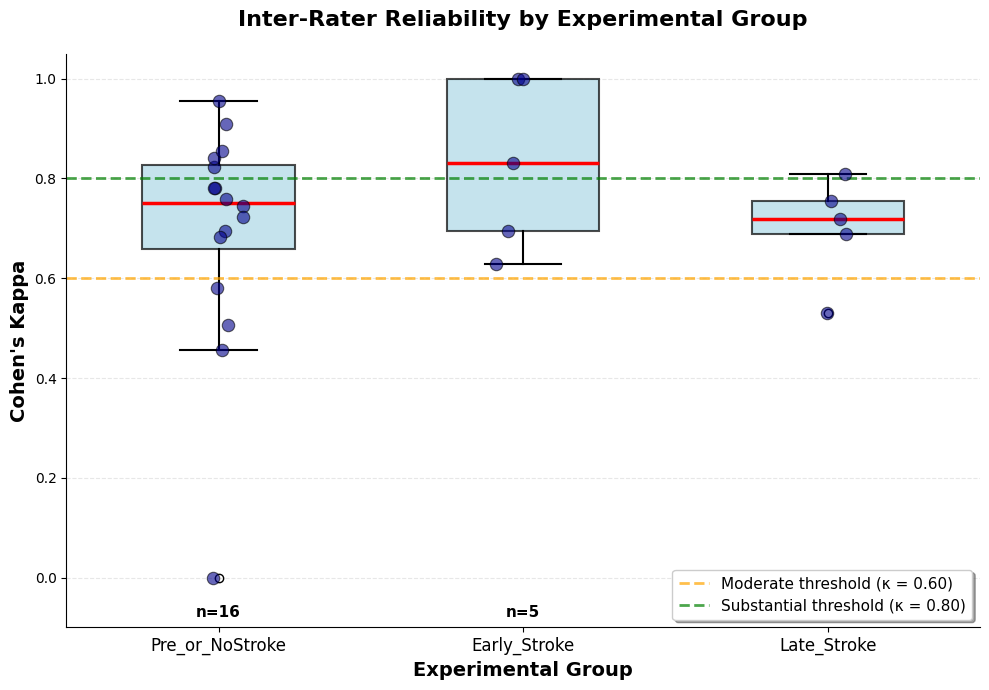


Cohen's Kappa by Experimental Group

Pre_or_NoStroke:
  n = 16 sessions
  Mean: 0.693 ± 0.057 (SEM)
  Median: 0.751
  Range: [0.000, 0.955]

Early_Stroke:
  n = 5 sessions
  Mean: 0.831 ± 0.076 (SEM)
  Median: 0.831
  Range: [0.628, 1.000]

Late_Stroke:
  n = 5 sessions
  Mean: 0.700 ± 0.047 (SEM)
  Median: 0.719
  Range: [0.529, 0.808]


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kappa_by_group(comparison_results, groups_df, save_path=None):
    """
    Simple plot of Cohen's Kappa by experimental group.
    
    Args:
        comparison_results: Output from compare_hand_scorers()
        groups_df: DataFrame with columns ['filename', 'phase', 'Stroke']
        save_path: Optional path to save the plot
    """
    # Get kappa results
    results_df = comparison_results['results_per_file']
    
    # Merge with groups
    merged = results_df.merge(groups_df, on='filename', how='left')
    
    # Create combined group
    merged['group'] = 'Other'
    merged.loc[(merged['phase'] == 'Pre_Stroke') | (merged['Stroke'] == 'n'), 'group'] = 'Pre_or_NoStroke'
    merged.loc[(merged['phase'] == 'early') & (merged['Stroke'] == 'y'), 'group'] = 'Early_Stroke'
    merged.loc[(merged['phase'] == 'Late') & (merged['Stroke'] == 'y'), 'group'] = 'Late_Stroke'
    
    # Define group order
    group_order = ['Pre_or_NoStroke', 'Early_Stroke', 'Late_Stroke']
    
    # Filter to groups
    plot_data = merged[merged['group'].isin(group_order)]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Box plot
    bp = ax.boxplot(
        [plot_data[plot_data['group'] == g]['cohen_kappa'].values for g in group_order],
        positions=range(len(group_order)),
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', alpha=0.7, edgecolor='black', linewidth=1.5),
        medianprops=dict(color='red', linewidth=2.5),
        whiskerprops=dict(linewidth=1.5),
        capprops=dict(linewidth=1.5)
    )
    
    # Add individual points with jitter
    for i, group in enumerate(group_order):
        group_data = plot_data[plot_data['group'] == group]['cohen_kappa'].values
        x_jitter = np.random.normal(i, 0.04, size=len(group_data))
        ax.scatter(x_jitter, group_data, alpha=0.6, s=80, 
                   color='darkblue', edgecolor='black', linewidth=0.8, zorder=3)
    
    # Reference lines
    ax.axhline(y=0.60, color='orange', linestyle='--', linewidth=2, 
               alpha=0.7, label='Moderate threshold (κ = 0.60)')
    ax.axhline(y=0.80, color='green', linestyle='--', linewidth=2, 
               alpha=0.7, label='Substantial threshold (κ = 0.80)')
    
    # Styling
    ax.set_ylabel("Cohen's Kappa", fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Group', fontsize=14, fontweight='bold')
    ax.set_title("Inter-Rater Reliability by Experimental Group", 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(range(len(group_order)))
    ax.set_xticklabels(group_order, fontsize=12)
    ax.set_ylim(-0.1, 1.05)
    ax.legend(fontsize=11, loc='lower right', frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add sample sizes below x-axis
    for i, group in enumerate(group_order):
        n = len(plot_data[plot_data['group'] == group])
        ax.text(i, -0.08, f'n={n}', ha='center', fontsize=11, fontweight='bold')
    
    sns.despine(ax=ax)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()
    
    # Print statistics
    print("\n" + "="*60)
    print("Cohen's Kappa by Experimental Group")
    print("="*60)
    
    for group in group_order:
        group_data = plot_data[plot_data['group'] == group]
        print(f"\n{group}:")
        print(f"  n = {len(group_data)} sessions")
        print(f"  Mean: {group_data['cohen_kappa'].mean():.3f} ± {group_data['cohen_kappa'].sem():.3f} (SEM)")
        print(f"  Median: {group_data['cohen_kappa'].median():.3f}")
        print(f"  Range: [{group_data['cohen_kappa'].min():.3f}, {group_data['cohen_kappa'].max():.3f}]")


# ====================
# ============================================================================
# USAGE
# ============================================================================

# Assuming you have:
# - comparison_results from compare_hand_scorers()
# - groups_df with columns: filename, phase, Stroke

plot_kappa_by_group(
    comparison_results, 
    df_gemini,
    save_path='kappa_by_group.svg'
)

In [ ]:
# Get kappa results


Sessions with NaN kappa: 0

No NaN kappa values found!


In [82]:
# Get all sessions from comparison results
results_sessions = set(comparison_results['results_per_file']['filename'])

# Get all sessions from groups_df
groups_sessions = set(groups_df['filename'])

# Find sessions in results but NOT in groups_df
missing_from_groups = results_sessions - groups_sessions
print(f"Sessions in results but missing from groups_df: {missing_from_groups}")

# Find sessions in groups_df but NOT in results
missing_from_results = groups_sessions - results_sessions
print(f"Sessions in groups_df but missing from results: {missing_from_results}")

# Check total counts
print(f"\nTotal in results: {len(results_sessions)}")
print(f"Total in groups_df: {len(groups_sessions)}")
print(f"Total after merge: {len(comparison_results['results_per_file'].merge(groups_df, on='filename'))}")

Sessions in results but missing from groups_df: {'FJ_R2_2024-06-29_1.csv', 'FJ_R3_2024-06-29_1.csv', 'FJ_L3_2024-07-15_1.csv', 'K_R2_2025-01-14_1.csv', 'FJ_R2_2024-07-29_1.csv', 'FS_R2_2024-06-29_1.csv', 'AZ_R2_2024-12-29_1.csv', 'FS_L2_2024-07-31_1.csv', 'K_R3_2025-02-21_1.csv', 'FS_L2_2024-06-28_1.csv', 'K_R3_2025-01-13_1.csv', 'FJ_R2_2024-07-15_1.csv', 'FJ_L2_2024-06-29_1.csv', 'FJ_L3_2024-06-29_1.csv', 'K_R2_2025-02-04_1.csv', 'FJ_L3_2024-07-29_1.csv', 'AZ_L3_2024-12-16_1.csv', 'FU_R2_2024-06-29_1.csv', 'AZ_L3_2024-12-29_1.csv', 'FU_R2_2024-07-18_1.csv', 'AZ_R2_2024-12-14_1.csv', 'AZ_L3_2024-11-22_1.csv', 'FJ_L2_2024-07-15_1.csv', 'K_R3_2025-01-14_1.csv', 'AZ_R2_2024-11-22_1.csv'}
Sessions in groups_df but missing from results: {Ellipsis}

Total in results: 27
Total in groups_df: 3
Total after merge: 2


✅ Plot saved to kappa_by_group.svg


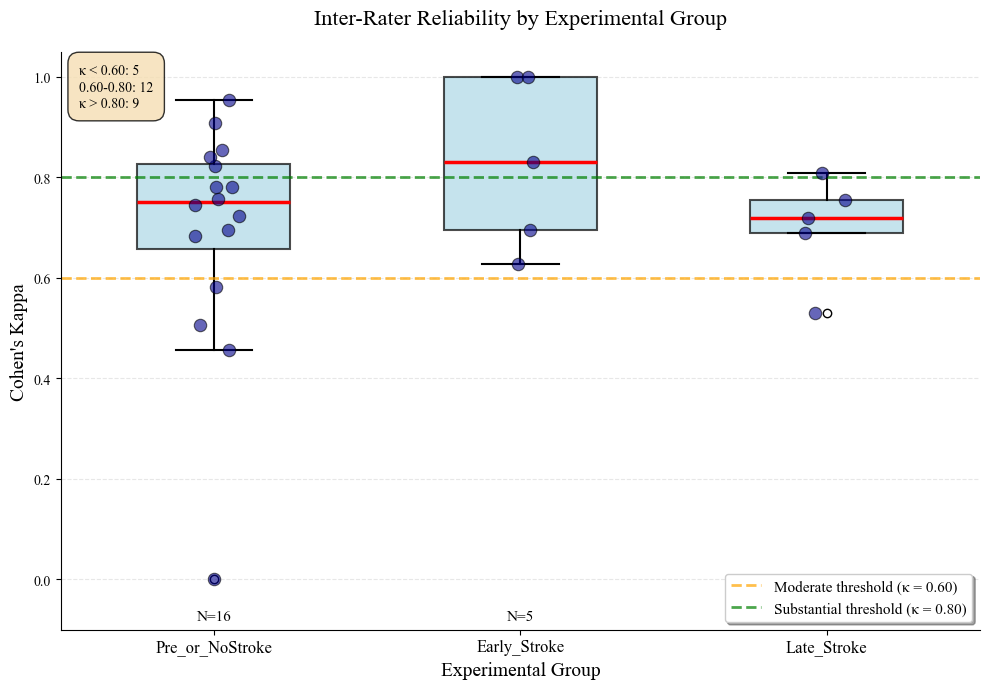


Cohen's Kappa by Experimental Group

Pre_or_NoStroke:
  n = 16 sessions
  Mean: 0.693 ± 0.057 (SEM)
  Median: 0.751
  Range: [0.000, 0.955]
  Sessions by agreement level:
    Below 0.60 (Weak):         4 (25.0%)
    0.60-0.80 (Substantial):   7 (43.8%)
    Above 0.80 (Almost Perfect): 5 (31.2%)

Early_Stroke:
  n = 5 sessions
  Mean: 0.831 ± 0.076 (SEM)
  Median: 0.831
  Range: [0.628, 1.000]
  Sessions by agreement level:
    Below 0.60 (Weak):         0 (0.0%)
    0.60-0.80 (Substantial):   2 (40.0%)
    Above 0.80 (Almost Perfect): 3 (60.0%)

Late_Stroke:
  n = 5 sessions
  Mean: 0.700 ± 0.047 (SEM)
  Median: 0.719
  Range: [0.529, 0.808]
  Sessions by agreement level:
    Below 0.60 (Weak):         1 (20.0%)
    0.60-0.80 (Substantial):   3 (60.0%)
    Above 0.80 (Almost Perfect): 1 (20.0%)


In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kappa_by_group(comparison_results, groups_df, save_path=None):
    """
    Simple plot of Cohen's Kappa by experimental group.
    
    Args:
        comparison_results: Output from compare_hand_scorers()
        groups_df: DataFrame with columns ['filename', 'phase', 'Stroke']
        save_path: Optional path to save the plot
    """
    # Get kappa results
    plt.rcParams['font.family'] = 'Times New Roman'
    results_df = comparison_results['results_per_file']
    
    # Merge with groups
    merged = results_df.merge(groups_df, on='filename', how='left')
    
    # Create combined group
    merged['group'] = 'Other'
    merged.loc[(merged['phase'] == 'Pre_Stroke') | (merged['Stroke'] == 'n'), 'group'] = 'Pre_or_NoStroke'
    merged.loc[(merged['phase'] == 'early') & (merged['Stroke'] == 'y'), 'group'] = 'Early_Stroke'
    merged.loc[(merged['phase'] == 'Late') & (merged['Stroke'] == 'y'), 'group'] = 'Late_Stroke'
    
    # Define group order
    group_order = ['Pre_or_NoStroke', 'Early_Stroke', 'Late_Stroke']
    
    # Filter to groups
    plot_data = merged[merged['group'].isin(group_order)]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Box plot
    bp = ax.boxplot(
        [plot_data[plot_data['group'] == g]['cohen_kappa'].values for g in group_order],
        positions=range(len(group_order)),
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', alpha=0.7, edgecolor='black', linewidth=1.5),
        medianprops=dict(color='red', linewidth=2.5),
        whiskerprops=dict(linewidth=1.5),
        capprops=dict(linewidth=1.5)
    )
    
    # Add individual points with jitter
    for i, group in enumerate(group_order):
        group_data = plot_data[plot_data['group'] == group]['cohen_kappa'].values
        x_jitter = np.random.normal(i, 0.04, size=len(group_data))
        ax.scatter(x_jitter, group_data, alpha=0.6, s=80, 
                   color='darkblue', edgecolor='black', linewidth=0.8, zorder=3)
    
    # Reference lines
    ax.axhline(y=0.60, color='orange', linestyle='--', linewidth=2, 
               alpha=0.7, label='Moderate threshold (κ = 0.60)')
    ax.axhline(y=0.80, color='green', linestyle='--', linewidth=2, 
               alpha=0.7, label='Substantial threshold (κ = 0.80)')
    
    # Styling
    ax.set_ylabel("Cohen's Kappa", fontsize=14)
    ax.set_xlabel('Experimental Group', fontsize=14)
    ax.set_title("Inter-Rater Reliability by Experimental Group", 
                 fontsize=16, pad=20)
    ax.set_xticks(range(len(group_order)))
    ax.set_xticklabels(group_order, fontsize=12)
    ax.set_ylim(-0.1, 1.05)
    ax.legend(fontsize=11, loc='lower right', frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add sample sizes below x-axis
    for i, group in enumerate(group_order):
        n = len(plot_data[plot_data['group'] == group])
        ax.text(i, -0.08, f'N={n}', ha='center', fontsize=11)
    
    # Calculate threshold counts across ALL groups
    all_kappas = plot_data['cohen_kappa']
    
    below_60 = (all_kappas < 0.60).sum()
    between_60_80 = ((all_kappas >= 0.60) & (all_kappas < 0.80)).sum()
    above_80 = (all_kappas >= 0.80).sum()
    
    # Add text box with overall counts
    full_text = f'κ < 0.60: {below_60}\n0.60-0.80: {between_60_80}\nκ > 0.80: {above_80}'
    ax.text(0.02, 0.98, full_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='wheat', alpha=0.8, edgecolor='black'))
    
    sns.despine(ax=ax)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()
    
    # Print statistics
    print("\n" + "="*60)
    print("Cohen's Kappa by Experimental Group")
    print("="*60)
    
    for group in group_order:
        group_data = plot_data[plot_data['group'] == group]
        kappas = group_data['cohen_kappa']
        
        # Count sessions by threshold
        below_60 = (kappas < 0.60).sum()
        between_60_80 = ((kappas >= 0.60) & (kappas < 0.80)).sum()
        above_80 = (kappas >= 0.80).sum()
        
        print(f"\n{group}:")
        print(f"  n = {len(group_data)} sessions")
        print(f"  Mean: {kappas.mean():.3f} ± {kappas.sem():.3f} (SEM)")
        print(f"  Median: {kappas.median():.3f}")
        print(f"  Range: [{kappas.min():.3f}, {kappas.max():.3f}]")
        print(f"  Sessions by agreement level:")
        print(f"    Below 0.60 (Weak):         {below_60} ({100*below_60/len(group_data):.1f}%)")
        print(f"    0.60-0.80 (Substantial):   {between_60_80} ({100*between_60_80/len(group_data):.1f}%)")
        print(f"    Above 0.80 (Almost Perfect): {above_80} ({100*above_80/len(group_data):.1f}%)")


# ============================================================================
# USAGE
# ============================================================================

# Assuming you have:
# - comparison_results from compare_hand_scorers()
# - groups_df with columns: filename, phase, Stroke

plot_kappa_by_group(
    comparison_results, 
    df_gemini,
    save_path='kappa_by_group.svg'
)


✅ Plot saved to person2_performance_by_group.svg


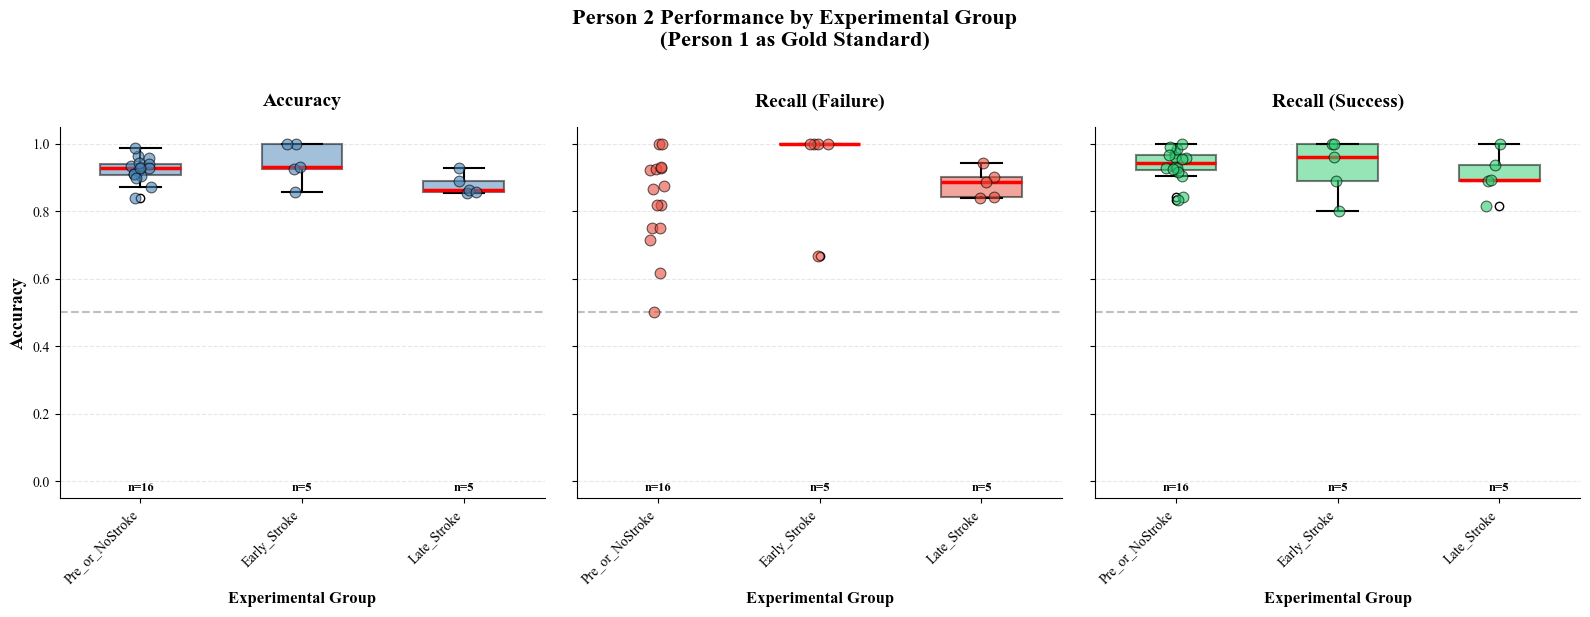


Person 2 Performance by Experimental Group (Person 1 as Gold Standard)

Pre_or_NoStroke (n=16):
  Accuracy:        0.922 ± 0.009
  Recall (Failure): 0.827 ± 0.036
  Recall (Success): 0.937 ± 0.012

Early_Stroke (n=5):
  Accuracy:        0.942 ± 0.027
  Recall (Failure): 0.933 ± 0.067
  Recall (Success): 0.930 ± 0.038

Late_Stroke (n=5):
  Accuracy:        0.878 ± 0.014
  Recall (Failure): 0.882 ± 0.019
  Recall (Success): 0.907 ± 0.030
✅ Plot saved to person2_performance_combined.svg


/tmp/ipykernel_1730669/3837150878.py:60: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
/tmp/ipykernel_1730669/3837150878.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='center')


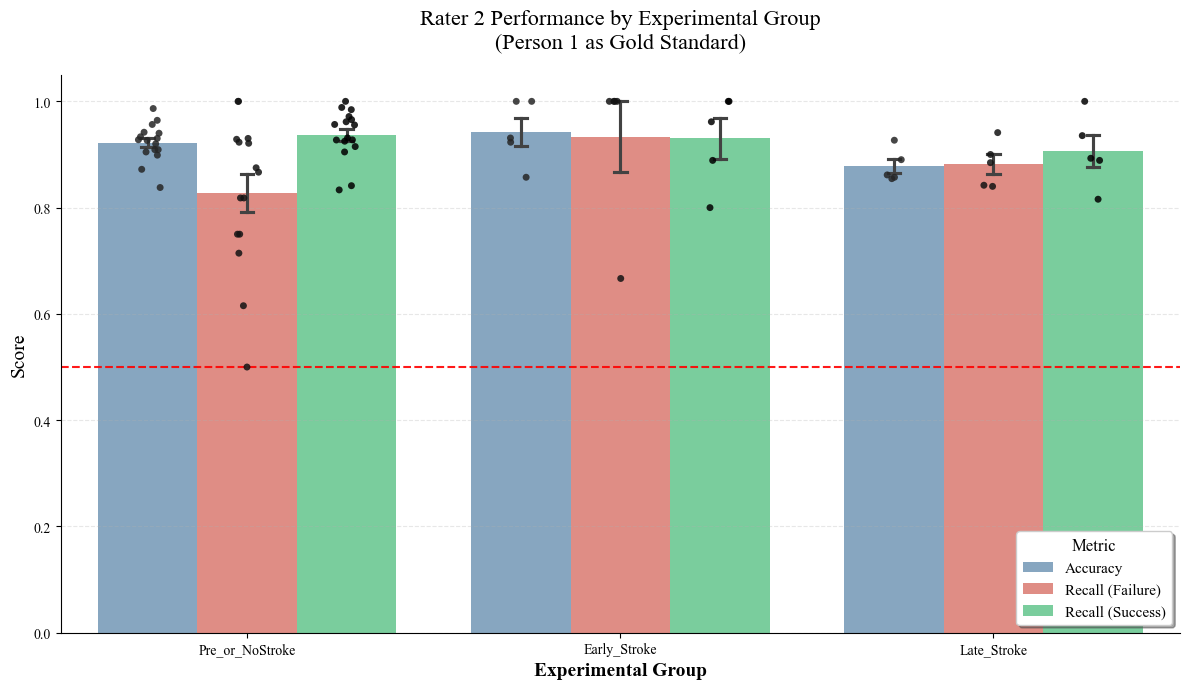

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics(y_true, y_pred, filename="", balance=True):
    """
    Calculate all evaluation metrics with optional class balancing and mismatch detection.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        filename: Name of file being processed (for logging)
        balance: Whether to balance classes before calculating metrics (default: True)
        
    Returns:
        Dictionary containing all metrics and mismatch info
    """
    # CHECK FOR CLASS MISMATCHES FIRST
    mismatch_info = check_class_mismatch(y_true, y_pred, filename)
    
    # Convert to arrays if needed
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # BALANCE CLASSES if requested
    if balance:
        # Count each class
        unique_classes, counts = np.unique(y_true, return_counts=True)
        
        if len(unique_classes) > 1:
            min_count = counts.min()
            
            print(f"  Balancing classes to {min_count} samples per class...")
            
            # Indices for balanced dataset
            balanced_indices = []
            
            for cls in unique_classes:
                cls_indices = np.where(y_true == cls)[0]
                # Randomly sample min_count indices
                sampled_indices = np.random.choice(cls_indices, size=min_count, replace=False)
                balanced_indices.extend(sampled_indices)
            
            # Shuffle to mix classes
            np.random.shuffle(balanced_indices)
            
            # Apply balancing
            y_true = y_true[balanced_indices]
            y_pred = y_pred[balanced_indices]
            
            print(f"  Balanced dataset: {len(y_true)} total samples")
        else:
            print(f"  ⚠️  Only one class present, cannot balance")
    
    # Get all labels (union of both sets)
    labels = sorted(list(set(y_true) | set(y_pred)))
    
    # Capture warnings during metrics calculation
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
        macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        
        # Calculate per-class F1 scores
        f1_per_class = f1_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        
        # Classification report as dictionary
        report_dict = classification_report(
            y_true, y_pred, 
            labels=labels, 
            zero_division=0, 
            output_dict=True
        )
        
        # Check if warnings were raised
        if len(w) > 0:
            print(f"  ⚠️  {len(w)} warning(s) occurred during metrics calculation:")
            for warning in w:
                print(f"     {warning.category.__name__}: {warning.message}")
    
    # Create F1 score dictionary for each class
    f1_scores = {}
    for label, f1_val in zip(labels, f1_per_class):
        f1_scores[f'{label}'] = f1_val
    
    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'macro_f1': macro_f1,
        'f1_scores': f1_scores,  # NEW: Dictionary of per-class F1 scores
        'confusion_matrix': cm,
        'report_dict': report_dict,
        'labels': labels,
        'mismatch_info': mismatch_info,
        'n_samples': len(y_true),
        'balanced': balance
    }


def plot_person2_performance_by_group(comparison_results, groups_df, save_path=None):
    """
    Plot Person 2's accuracy and recall by experimental group (Person 1 as gold standard).
    
    Args:
        comparison_results: Output from compare_hand_scorers()
        groups_df: DataFrame with columns ['filename', 'phase', 'Stroke']
        save_path: Optional path to save the plot
    """
    # Set Times New Roman font
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # Calculate performance metrics
    perf_df = calculate_person2_performance(comparison_results)
    
    # Merge with groups
    merged = perf_df.merge(groups_df, on='filename', how='left')
    
    # Create combined group
    merged['group'] = 'Other'
    merged.loc[(merged['phase'] == 'Pre_Stroke') | (merged['Stroke'] == 'n'), 'group'] = 'Pre_or_NoStroke'
    merged.loc[(merged['phase'] == 'early') & (merged['Stroke'] == 'y'), 'group'] = 'Early_Stroke'
    merged.loc[(merged['phase'] == 'Late') & (merged['Stroke'] == 'y'), 'group'] = 'Late_Stroke'
    
    # Define group order
    group_order = ['Pre_or_NoStroke', 'Early_Stroke', 'Late_Stroke']
    
    # Filter to groups
    plot_data = merged[merged['group'].isin(group_order)]
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    
    metrics = ['person2_accuracy', 'recall_f', 'recall_s']
    titles = ['Accuracy', 'Recall (Failure)', 'Recall (Success)']
    colors = ['steelblue', '#e74c3c', '#2ecc71']
    
    for ax, metric, title, color in zip(axes, metrics, titles, colors):
        # Box plot
        bp = ax.boxplot(
            [plot_data[plot_data['group'] == g][metric].values for g in group_order],
            positions=range(len(group_order)),
            widths=0.5,
            patch_artist=True,
            boxprops=dict(facecolor=color, alpha=0.5, edgecolor='black', linewidth=1.5),
            medianprops=dict(color='red', linewidth=2.5),
            whiskerprops=dict(linewidth=1.5),
            capprops=dict(linewidth=1.5)
        )
        
        # Add individual points with jitter
        for i, group in enumerate(group_order):
            group_data = plot_data[plot_data['group'] == group][metric].values
            # Remove NaN values
            group_data = group_data[~np.isnan(group_data)]
            x_jitter = np.random.normal(i, 0.04, size=len(group_data))
            ax.scatter(x_jitter, group_data, alpha=0.6, s=60, 
                      facecolor=color, edgecolor='black', linewidth=0.8, zorder=3)
        
        # Styling
        ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
        ax.set_ylabel(title if ax == axes[0] else '', fontsize=13, fontweight='bold')
        ax.set_xlabel('Experimental Group', fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
        ax.set_xticks(range(len(group_order)))
        ax.set_xticklabels(group_order, fontsize=10, rotation=45, ha='right')
        ax.set_ylim(-0.05, 1.05)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add sample sizes
        for i, group in enumerate(group_order):
            n = len(plot_data[plot_data['group'] == group])
            ax.text(i, -0.03, f'n={n}', ha='center', fontsize=9, fontweight='bold')
        
        sns.despine(ax=ax)
    
    plt.suptitle("Person 2 Performance by Experimental Group\n(Person 1 as Gold Standard)", 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()
    
    # Print statistics
    print("\n" + "="*70)
    print("Person 2 Performance by Experimental Group (Person 1 as Gold Standard)")
    print("="*70)
    
    for group in group_order:
        group_data = plot_data[plot_data['group'] == group]
        
        print(f"\n{group} (n={len(group_data)}):")
        print(f"  Accuracy:        {group_data['person2_accuracy'].mean():.3f} ± {group_data['person2_accuracy'].sem():.3f}")
        print(f"  Recall (Failure): {group_data['recall_f'].mean():.3f} ± {group_data['recall_f'].sem():.3f}")
        print(f"  Recall (Success): {group_data['recall_s'].mean():.3f} ± {group_data['recall_s'].sem():.3f}")
    
    return plot_data




# ============================================================================
# USAGE
# ============================================================================

# Option 1: Three separate subplots (side-by-side)
plot_person2_performance_by_group(
    comparison_results, 
    df_gemini,
    save_path='person2_performance_by_group.svg'
)

# Option 2: All metrics in one plot with grouped bars
plot_person2_combined_metrics(
    comparison_results,
    df_gemini,
    save_path='person2_performance_combined.svg'
)

Found 27 files scored by both raters


📄 AZ_L3_2024-11-22_1.csv
--------------------------------------------------------------------------------
  Total valid trials: 50
  Agreements: 46 (92.0%)
  Disagreements: 4 (8.0%)
  Accuracy: 0.9200
  Cohen's Kappa: 0.4565

  Rater 1 distribution:
    s: 46 (92.0%)
    f: 4 (8.0%)
  Rater 2 distribution:
    s: 46 (92.0%)
    f: 4 (8.0%)

  Confusion Matrix (Rater1=rows, Rater2=cols):
           f    s
    f      2    2
    s      2   44

📄 AZ_L3_2024-12-16_1.csv
--------------------------------------------------------------------------------
  Total valid trials: 26
  Agreements: 24 (92.3%)
  Disagreements: 2 (7.7%)
  Accuracy: 0.9231
  Cohen's Kappa: 0.8312

  Rater 1 distribution:
    s: 18 (69.2%)
    f: 8 (30.8%)
  Rater 2 distribution:
    s: 16 (61.5%)
    f: 10 (38.5%)

  Confusion Matrix (Rater1=rows, Rater2=cols):
           f    s
    f      8    0
    s      2   16

📄 AZ_L3_2024-12-29_1.csv
-------------------------------------------

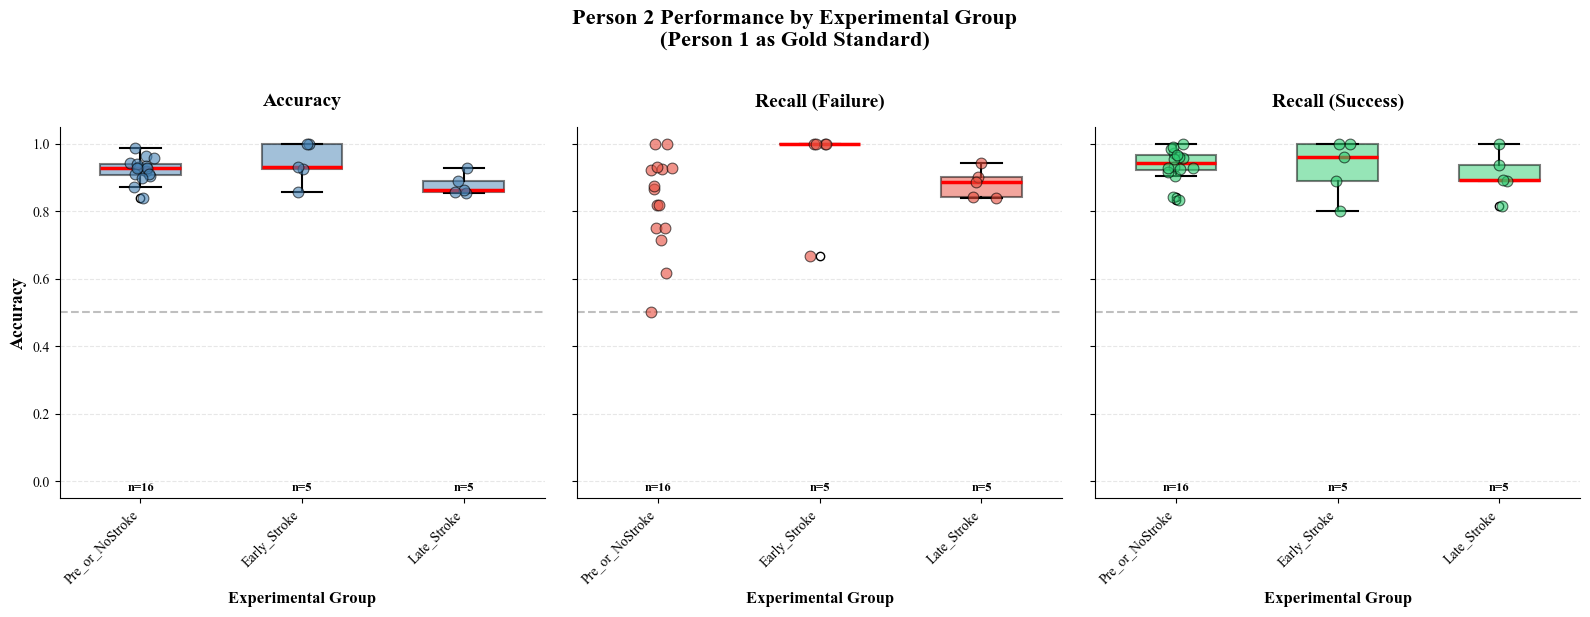


Person 2 Performance by Experimental Group (Person 1 as Gold Standard)

Pre_or_NoStroke (n=16):
  Accuracy:        0.922 ± 0.009
  Recall (Failure): 0.827 ± 0.036
  Recall (Success): 0.937 ± 0.012

Early_Stroke (n=5):
  Accuracy:        0.942 ± 0.027
  Recall (Failure): 0.933 ± 0.067
  Recall (Success): 0.930 ± 0.038

Late_Stroke (n=5):
  Accuracy:        0.878 ± 0.014
  Recall (Failure): 0.882 ± 0.019
  Recall (Success): 0.907 ± 0.030
Found 27 files scored by both raters


📄 AZ_L3_2024-11-22_1.csv
--------------------------------------------------------------------------------
  Total valid trials: 8
  Agreements: 6 (75.0%)
  Disagreements: 2 (25.0%)
  Accuracy: 0.7500
  Cohen's Kappa: 0.5000

  Rater 1 distribution:
    f: 4 (50.0%)
    s: 4 (50.0%)
  Rater 2 distribution:
    s: 6 (75.0%)
    f: 2 (25.0%)

  Confusion Matrix (Rater1=rows, Rater2=cols):
           f    s
    f      2    2
    s      0    4

📄 AZ_L3_2024-12-16_1.csv
---------------------------------------------------

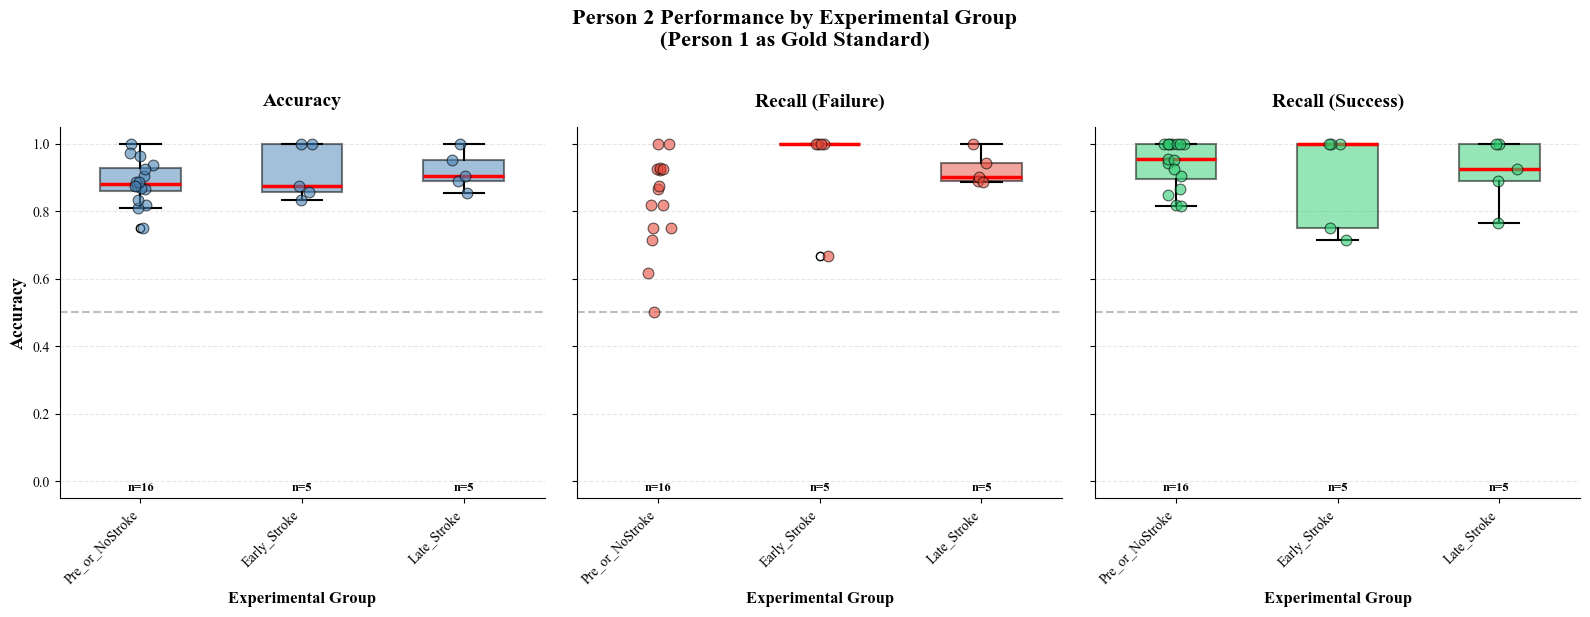


Person 2 Performance by Experimental Group (Person 1 as Gold Standard)

Pre_or_NoStroke (n=16):
  Accuracy:        0.885 ± 0.016
  Recall (Failure): 0.827 ± 0.036
  Recall (Success): 0.939 ± 0.017

Early_Stroke (n=5):
  Accuracy:        0.913 ± 0.036
  Recall (Failure): 0.933 ± 0.067
  Recall (Success): 0.893 ± 0.066

Late_Stroke (n=5):
  Accuracy:        0.919 ± 0.026
  Recall (Failure): 0.923 ± 0.022
  Recall (Success): 0.915 ± 0.043


,filename,total_trials,agreements,disagreements,accuracy,cohen_kappa,rater1_f,rater1_s,rater2_f,rater2_s,cm_ff,cm_fs,cm_sf,cm_ss,person2_accuracy,recall_f,recall_s,phase,Stroke,group
0,AZ_L3_2024-11-22_1.csv,8,6,2,0.750000,0.500000,4,4,2,6,2,2,0,4,0.750000,0.500000,1.000000,Pre_Stroke,y,Pre_or_NoStroke
1,AZ_L3_2024-12-16_1.csv,16,14,2,0.875000,0.750000,8,8,10,6,8,0,2,6,0.875000,1.000000,0.750000,early,y,Early_Stroke
2,AZ_L3_2024-12-29_1.csv,34,29,5,0.852941,0.705882,17,17,20,14,16,1,4,13,0.852941,0.941176,0.764706,Late,y,Late_Stroke
3,AZ_R2_2024-11-22_1.csv,22,18,4,0.818182,0.636364,11,11,11,11,9,2,2,9,0.818182,0.818182,0.818182,Pre_Stroke,n,Pre_or_NoStroke
4,AZ_R2_2024-12-14_1.csv,16,14,2,0.875000,0.750000,8,8,6,10,6,2,0,8,0.875000,0.750000,1.000000,early,n,Pre_or_NoStroke
5,AZ_R2_2024-12-29_1.csv,4,4,0,1.000000,1.000000,2,2,2,2,2,0,0,2,1.000000,1.000000,1.000000,Late,n,Pre_or_NoStroke
6,FJ_L2_2024-06-29_1.csv,34,33,1,0.970588,0.941176,17,17,18,16,17,0,1,16,0.970588,1.000000,0.941176,Pre_Stroke,y,Pre_or_NoStroke
7,FJ_L2_2024-07-15_1.csv,6,5,1,0.833333,0.666667,3,3,2,4,2,1,0,3,0.833333,0.666667,1.000000,early,y,Early_Stroke
8,FJ_L3_2024-06-29_1.csv,30,26,4,0.866667,0.733333,15,15,15,15,13,2,2,13,0.866667,0.866667,0.866667,Pre_Stroke,y,Pre_or_NoStroke
9,FJ_L3_2024-07-15_1.csv,28,24,4,0.857143,0.714286,14,14,18,10,14,0,4,10,0.857143,1.000000,0.714286,early,y,Early_Stroke


In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import accuracy_score


def compare_hand_scorers(hand_scored_data, hand_scored_data2, merge_on='trial'):
    """
    Compare two hand-scorers and calculate inter-rater reliability metrics.
    
    Args:
        hand_scored_data: Dictionary of DataFrames from first scorer
        hand_scored_data2: Dictionary of DataFrames from second scorer
        merge_on: Column to merge on (default: 'trial')
    
    Returns:
        Dictionary containing comparison results and metrics
    """
    
    results = []
    all_rater1 = []
    all_rater2 = []
    
    # Find common files
    common_files = set(hand_scored_data.keys()) & set(hand_scored_data2.keys())
    
    print(f"Found {len(common_files)} files scored by both raters\n")
    print("="*80)
    
    for filename in sorted(common_files):
        df1 = hand_scored_data[filename]
        df2 = hand_scored_data2[filename]
        
        print(f"\n📄 {filename}")
        print("-"*80)
        
        # Merge on trial number or index
        if merge_on in df1.columns and merge_on in df2.columns:
            merged = pd.merge(df1[[merge_on, 'outcome']], 
                            df2[[merge_on, 'outcome']], 
                            on=merge_on, 
                            suffixes=('_rater1', '_rater2'))
        else:
            # Merge on index if no trial column
            merged = pd.merge(df1[['outcome']], 
                            df2[['outcome']], 
                            left_index=True, 
                            right_index=True, 
                            suffixes=('_rater1', '_rater2'))
        
        # Remove rows where either rater has NA, ND, or missing values
        valid_mask = (
            merged['outcome_rater1'].notna() & 
            merged['outcome_rater2'].notna() &
            ~merged['outcome_rater1'].isin(['na', 'nd', 'NA', 'ND']) &
            ~merged['outcome_rater2'].isin(['na', 'nd', 'NA', 'ND'])
        )
        
        merged_clean = merged[valid_mask].copy()
        
        if len(merged_clean) == 0:
            print(f"  ⚠️  No valid overlapping scores")
            continue
        
        # Extract ratings
        rater1 = merged_clean['outcome_rater1'].values
        rater2 = merged_clean['outcome_rater2'].values
        
        # Add to overall lists
        all_rater1.extend(rater1)
        all_rater2.extend(rater2)
        
        # Calculate metrics
        accuracy = accuracy_score(rater1, rater2)
        kappa = cohen_kappa_score(rater1, rater2)
        
        # Confusion matrix
        cm = confusion_matrix(rater1, rater2, labels=['f', 's'])
        
        # Agreement counts
        total = len(rater1)
        agreements = (rater1 == rater2).sum()
        disagreements = (rater1 != rater2).sum()
        
        # Class distributions
        rater1_dist = pd.Series(rater1).value_counts()
        rater2_dist = pd.Series(rater2).value_counts()
        
        print(f"  Total valid trials: {total}")
        print(f"  Agreements: {agreements} ({100*agreements/total:.1f}%)")
        print(f"  Disagreements: {disagreements} ({100*disagreements/total:.1f}%)")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Cohen's Kappa: {kappa:.4f}")
        
        print(f"\n  Rater 1 distribution:")
        for label, count in rater1_dist.items():
            print(f"    {label}: {count} ({100*count/total:.1f}%)")
        
        print(f"  Rater 2 distribution:")
        for label, count in rater2_dist.items():
            print(f"    {label}: {count} ({100*count/total:.1f}%)")
        
        print(f"\n  Confusion Matrix (Rater1=rows, Rater2=cols):")
        print(f"           f    s")
        print(f"    f    {cm[0,0]:3d}  {cm[0,1]:3d}")
        print(f"    s    {cm[1,0]:3d}  {cm[1,1]:3d}")
        
        # Store results
        results.append({
            'filename': filename,
            'total_trials': total,
            'agreements': agreements,
            'disagreements': disagreements,
            'accuracy': accuracy,
            'cohen_kappa': kappa,
            'rater1_f': rater1_dist.get('f', 0),
            'rater1_s': rater1_dist.get('s', 0),
            'rater2_f': rater2_dist.get('f', 0),
            'rater2_s': rater2_dist.get('s', 0),
            'cm_ff': cm[0,0],
            'cm_fs': cm[0,1],
            'cm_sf': cm[1,0],
            'cm_ss': cm[1,1]
        })
    
    # Overall statistics
    print("\n" + "="*80)
    print("📊 OVERALL INTER-RATER RELIABILITY")
    print("="*80)
    
    all_rater1 = np.array(all_rater1)
    all_rater2 = np.array(all_rater2)
    
    overall_accuracy = accuracy_score(all_rater1, all_rater2)
    overall_kappa = cohen_kappa_score(all_rater1, all_rater2)
    overall_cm = confusion_matrix(all_rater1, all_rater2, labels=['f', 's'])
    
    total_all = len(all_rater1)
    agreements_all = (all_rater1 == all_rater2).sum()
    disagreements_all = (all_rater1 != all_rater2).sum()
    
    print(f"\nTotal trials scored by both: {total_all}")
    print(f"Total agreements: {agreements_all} ({100*agreements_all/total_all:.1f}%)")
    print(f"Total disagreements: {disagreements_all} ({100*disagreements_all/total_all:.1f}%)")
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
    print(f"Overall Cohen's Kappa: {overall_kappa:.4f}")
    
    print(f"\nKappa Interpretation:")
    if overall_kappa < 0:
        print("  ⚠️  Poor agreement (worse than chance)")
    elif overall_kappa < 0.20:
        print("  ⚠️  Slight agreement")
    elif overall_kappa < 0.40:
        print("  ⚠️  Fair agreement")
    elif overall_kappa < 0.60:
        print("  ✓  Moderate agreement")
    elif overall_kappa < 0.80:
        print("  ✓✓ Substantial agreement")
    else:
        print("  ✓✓✓ Almost perfect agreement")
    
    print(f"\nOverall Confusion Matrix (Rater1=rows, Rater2=cols):")
    print(f"           f      s")
    print(f"    f    {overall_cm[0,0]:4d}   {overall_cm[0,1]:4d}")
    print(f"    s    {overall_cm[1,0]:4d}   {overall_cm[1,1]:4d}")
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(all_rater1, all_rater2, target_names=['Failure', 'Success']))
    
    return {
        'results_per_file': pd.DataFrame(results),
        'overall_accuracy': overall_accuracy,
        'overall_kappa': overall_kappa,
        'overall_confusion_matrix': overall_cm,
        'all_rater1': all_rater1,
        'all_rater2': all_rater2
    }


def balance_comparison_data(hand_scored_data, hand_scored_data2, merge_on='trial', random_state=42):
    """
    Balance the comparison data before calculating metrics.
    
    Args:
        hand_scored_data: Dictionary of DataFrames from first scorer
        hand_scored_data2: Dictionary of DataFrames from second scorer
        merge_on: Column to merge on
        random_state: Random seed
        
    Returns:
        Tuple of (balanced_hand_scored_data, balanced_hand_scored_data2)
    """
    balanced_data1 = {}
    balanced_data2 = {}
    
    common_files = set(hand_scored_data.keys()) & set(hand_scored_data2.keys())
    
    for filename in common_files:
        df1 = hand_scored_data[filename].copy()
        df2 = hand_scored_data2[filename].copy()
        
        # Merge
        if merge_on in df1.columns and merge_on in df2.columns:
            merged = pd.merge(df1[[merge_on, 'outcome']], 
                            df2[[merge_on, 'outcome']], 
                            on=merge_on, 
                            suffixes=('_rater1', '_rater2'))
        else:
            merged = pd.merge(df1[['outcome']], 
                            df2[['outcome']], 
                            left_index=True, 
                            right_index=True, 
                            suffixes=('_rater1', '_rater2'))
        
        # Remove invalid
        valid_mask = (
            merged['outcome_rater1'].notna() & 
            merged['outcome_rater2'].notna() &
            ~merged['outcome_rater1'].isin(['na', 'nd', 'NA', 'ND']) &
            ~merged['outcome_rater2'].isin(['na', 'nd', 'NA', 'ND'])
        )
        merged = merged[valid_mask]
        
        if len(merged) == 0:
            continue
        
        # Balance based on rater1 (gold standard)
        class_counts = merged['outcome_rater1'].value_counts()
        
        if len(class_counts) > 1:
            min_count = class_counts.min()
            
            balanced_dfs = []
            for cls in class_counts.index:
                class_df = merged[merged['outcome_rater1'] == cls]
                if len(class_df) > min_count:
                    balanced_class_df = resample(
                        class_df,
                        replace=False,
                        n_samples=min_count,
                        random_state=random_state
                    )
                else:
                    balanced_class_df = class_df
                balanced_dfs.append(balanced_class_df)
            
            merged = pd.concat(balanced_dfs).sort_index()
        
        # Store balanced data
        balanced_data1[filename] = merged[['outcome_rater1']].rename(columns={'outcome_rater1': 'outcome'})
        balanced_data2[filename] = merged[['outcome_rater2']].rename(columns={'outcome_rater2': 'outcome'})
    
    return balanced_data1, balanced_data2


def calculate_person2_performance(comparison_results):
    """
    Calculate Person 2's accuracy and recall treating Person 1 as gold standard.
    
    Args:
        comparison_results: Output from compare_hand_scorers()
    
    Returns:
        DataFrame with performance metrics per session
    """
    results_df = comparison_results['results_per_file'].copy()
    
    # Calculate accuracy (already have this)
    results_df['person2_accuracy'] = results_df['accuracy']
    
    # Calculate recall for each class
    # Recall_f = TP_f / (TP_f + FN_f) = how many of Person1's 'f' did Person2 catch
    # Recall_s = TP_s / (TP_s + FN_s) = how many of Person1's 's' did Person2 catch
    
    # From confusion matrix:
    # Person1 (rows) vs Person2 (cols)
    results_df['recall_f'] = results_df['cm_ff'] / (results_df['cm_ff'] + results_df['cm_fs'])
    results_df['recall_s'] = results_df['cm_ss'] / (results_df['cm_sf'] + results_df['cm_ss'])
    
    return results_df


def plot_person2_performance_by_group(comparison_results, groups_df, save_path=None):
    """
    Plot Person 2's accuracy and recall by experimental group (Person 1 as gold standard).
    
    Args:
        comparison_results: Output from compare_hand_scorers()
        groups_df: DataFrame with columns ['filename', 'phase', 'Stroke']
        save_path: Optional path to save the plot
    """
    # Set Times New Roman font
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # Calculate performance metrics
    perf_df = calculate_person2_performance(comparison_results)
    
    # Merge with groups
    merged = perf_df.merge(groups_df, on='filename', how='left')
    
    # Create combined group
    merged['group'] = 'Other'
    merged.loc[(merged['phase'] == 'Pre_Stroke') | (merged['Stroke'] == 'n'), 'group'] = 'Pre_or_NoStroke'
    merged.loc[(merged['phase'] == 'early') & (merged['Stroke'] == 'y'), 'group'] = 'Early_Stroke'
    merged.loc[(merged['phase'] == 'Late') & (merged['Stroke'] == 'y'), 'group'] = 'Late_Stroke'
    
    # Define group order
    group_order = ['Pre_or_NoStroke', 'Early_Stroke', 'Late_Stroke']
    
    # Filter to groups
    plot_data = merged[merged['group'].isin(group_order)]
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    
    metrics = ['person2_accuracy', 'recall_f', 'recall_s']
    titles = ['Accuracy', 'Recall (Failure)', 'Recall (Success)']
    colors = ['steelblue', '#e74c3c', '#2ecc71']
    
    for ax, metric, title, color in zip(axes, metrics, titles, colors):
        # Box plot
        bp = ax.boxplot(
            [plot_data[plot_data['group'] == g][metric].values for g in group_order],
            positions=range(len(group_order)),
            widths=0.5,
            patch_artist=True,
            boxprops=dict(facecolor=color, alpha=0.5, edgecolor='black', linewidth=1.5),
            medianprops=dict(color='red', linewidth=2.5),
            whiskerprops=dict(linewidth=1.5),
            capprops=dict(linewidth=1.5)
        )
        
        # Add individual points with jitter
        for i, group in enumerate(group_order):
            group_data = plot_data[plot_data['group'] == group][metric].values
            # Remove NaN values
            group_data = group_data[~np.isnan(group_data)]
            x_jitter = np.random.normal(i, 0.04, size=len(group_data))
            ax.scatter(x_jitter, group_data, alpha=0.6, s=60, 
                      facecolor=color, edgecolor='black', linewidth=0.8, zorder=3)
        
        # Styling
        ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
        ax.set_ylabel(title if ax == axes[0] else '', fontsize=13, fontweight='bold')
        ax.set_xlabel('Experimental Group', fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
        ax.set_xticks(range(len(group_order)))
        ax.set_xticklabels(group_order, fontsize=10, rotation=45, ha='right')
        ax.set_ylim(-0.05, 1.05)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add sample sizes
        for i, group in enumerate(group_order):
            n = len(plot_data[plot_data['group'] == group])
            ax.text(i, -0.03, f'n={n}', ha='center', fontsize=9, fontweight='bold')
        
        sns.despine(ax=ax)
    
    plt.suptitle("Person 2 Performance by Experimental Group\n(Person 1 as Gold Standard)", 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()
    
    # Print statistics
    print("\n" + "="*70)
    print("Person 2 Performance by Experimental Group (Person 1 as Gold Standard)")
    print("="*70)
    
    for group in group_order:
        group_data = plot_data[plot_data['group'] == group]
        
        print(f"\n{group} (n={len(group_data)}):")
        print(f"  Accuracy:        {group_data['person2_accuracy'].mean():.3f} ± {group_data['person2_accuracy'].sem():.3f}")
        print(f"  Recall (Failure): {group_data['recall_f'].mean():.3f} ± {group_data['recall_f'].sem():.3f}")
        print(f"  Recall (Success): {group_data['recall_s'].mean():.3f} ± {group_data['recall_s'].sem():.3f}")
    
    return plot_data


def plot_person2_combined_metrics(comparison_results, groups_df, save_path=None):
    """
    Alternative: Single plot with all three metrics side-by-side for each group.
    """
    # Set Times New Roman font
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # Calculate performance metrics
    perf_df = calculate_person2_performance(comparison_results)
    
    # Merge with groups
    merged = perf_df.merge(groups_df, on='filename', how='left')
    
    # Create combined group
    merged['group'] = 'Other'
    merged.loc[(merged['phase'] == 'Pre_Stroke') | (merged['Stroke'] == 'n'), 'group'] = 'Pre_or_NoStroke'
    merged.loc[(merged['phase'] == 'early') & (merged['Stroke'] == 'y'), 'group'] = 'Early_Stroke'
    merged.loc[(merged['phase'] == 'Late') & (merged['Stroke'] == 'y'), 'group'] = 'Late_Stroke'
    
    # Define group order
    group_order = ['Pre_or_NoStroke', 'Early_Stroke', 'Late_Stroke']
    
    # Filter to groups
    plot_data = merged[merged['group'].isin(group_order)]
    
    # Melt data for plotting
    plot_data_melt = plot_data.melt(
        id_vars=['filename', 'group'],
        value_vars=['person2_accuracy', 'recall_f', 'recall_s'],
        var_name='metric',
        value_name='value'
    )
    
    # Rename metrics
    metric_names = {
        'person2_accuracy': 'Accuracy',
        'recall_f': 'Recall (Failure)',
        'recall_s': 'Recall (Success)'
    }
    plot_data_melt['metric'] = plot_data_melt['metric'].map(metric_names)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Bar plot with error bars
    sns.barplot(
        data=plot_data_melt,
        x='group',
        y='value',
        hue='metric',
        order=group_order,
        errorbar='se',
        capsize=0.1,
        palette=['steelblue', '#e74c3c', '#2ecc71'],
        alpha=0.7,
        ax=ax
    )
    
    # Scatter individual points
    sns.stripplot(
        data=plot_data_melt,
        x='group',
        y='value',
        hue='metric',
        order=group_order,
        dodge=True,
        jitter=True,
        alpha=0.5,
        size=5,
        palette=['steelblue', '#e74c3c', '#2ecc71'],
        ax=ax,
        legend=False
    )
    
    # Styling
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Group', fontsize=14, fontweight='bold')
    ax.set_title('Person 2 Performance by Experimental Group\n(Person 1 as Gold Standard)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 1.05)
    ax.legend(title='Metric', fontsize=11, title_fontsize=12, loc='lower right', frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    sns.despine(ax=ax)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()


# ============================================================================
# USAGE
# ============================================================================

# OPTION A: Without balancing (default)
comparison_results = compare_hand_scorers(hand_scored_data, hand_scored_data2)

plot_person2_performance_by_group(
    comparison_results, 
    df_gemini,
    save_path='person2_performance_by_group.svg'
)

# OPTION B: With balancing
# Step 1: Balance the raw data first
balanced_data1, balanced_data2 = balance_comparison_data(
    hand_scored_data, 
    hand_scored_data2, 
    merge_on='trial',
    random_state=42
)

# Step 2: Run comparison on balanced data
comparison_results_balanced = compare_hand_scorers(balanced_data1, balanced_data2)

# Step 3: Plot
plot_person2_performance_by_group(
    comparison_results_balanced, 
    df_gemini,
    save_path='person2_performance_balanced.svg'
)

✅ Plot saved to person2_performance_balanced.svg


/tmp/ipykernel_1730669/3837150878.py:60: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
/tmp/ipykernel_1730669/3837150878.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='center')


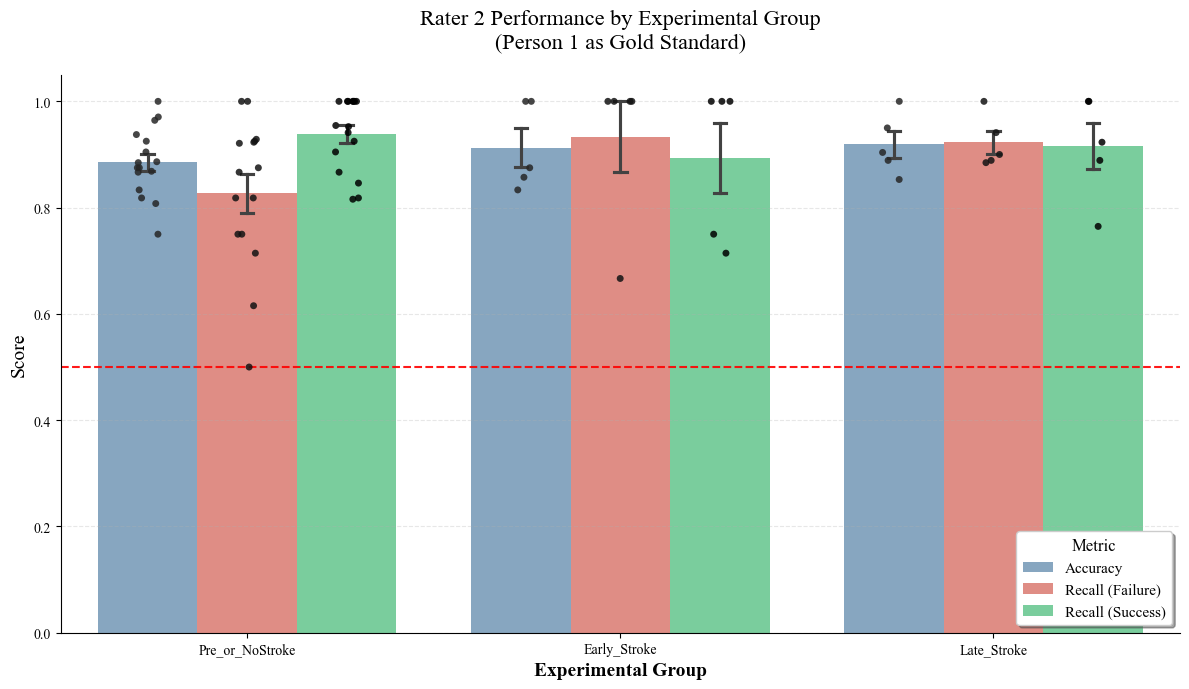

In [110]:
def plot_person2_combined_metrics(comparison_results, groups_df, save_path=None):
    """
    Alternative: Single plot with all three metrics side-by-side for each group.
    """
    # Set Times New Roman font
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # Calculate performance metrics
    perf_df = calculate_person2_performance(comparison_results)
    
    # Merge with groups
    merged = perf_df.merge(groups_df, on='filename', how='left')
    
    # Create combined group
    merged['group'] = 'Other'
    merged.loc[(merged['phase'] == 'Pre_Stroke') | (merged['Stroke'] == 'n'), 'group'] = 'Pre_or_NoStroke'
    merged.loc[(merged['phase'] == 'early') & (merged['Stroke'] == 'y'), 'group'] = 'Early_Stroke'
    merged.loc[(merged['phase'] == 'Late') & (merged['Stroke'] == 'y'), 'group'] = 'Late_Stroke'
    
    # Define group order
    group_order = ['Pre_or_NoStroke', 'Early_Stroke', 'Late_Stroke']
    
    # Filter to groups
    plot_data = merged[merged['group'].isin(group_order)]
    
    # Melt data for plotting
    plot_data_melt = plot_data.melt(
        id_vars=['filename', 'group'],
        value_vars=['person2_accuracy', 'recall_f', 'recall_s'],
        var_name='metric',
        value_name='value'
    )
    
    # Rename metrics
    metric_names = {
        'person2_accuracy': 'Accuracy',
        'recall_f': 'Recall (Failure)',
        'recall_s': 'Recall (Success)'
    }
    plot_data_melt['metric'] = plot_data_melt['metric'].map(metric_names)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Bar plot with error bars
    sns.barplot(
        data=plot_data_melt,
        x='group',
        y='value',
        hue='metric',
        order=group_order,
        errorbar='se',
        capsize=0.1,
        palette=['steelblue', '#e74c3c', '#2ecc71'],
        alpha=0.7,
        ax=ax
    )
    
    # Scatter individual points
    sns.stripplot(
        data=plot_data_melt,
        x='group',
        y='value',
        hue='metric',
        order=group_order,
        dodge=True,
        jitter=True,
        alpha=0.85,
        size=5,
        color='black',
        ax=ax,
        legend=False
    )
    
    # Styling
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.9)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_xlabel('Experimental Group', fontsize=14, fontweight='bold')
    ax.set_title('Rater 2 Performance by Experimental Group\n(Person 1 as Gold Standard)', 
                 fontsize=16, pad=20)
    ax.set_xticklabels(ax.get_xticklabels(), ha='center')
    ax.set_ylim(0, 1.05)
    ax.legend(title='Metric', fontsize=11, title_fontsize=12, loc='lower right', frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    sns.despine(ax=ax)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()

# Step 3: Plot
plot_person2_combined_metrics(
    comparison_results_balanced, 
    df_gemini,
    save_path='person2_performance_balanced.svg'
)

In [118]:
comparison_results_balanced.keys()






dict_keys(['results_per_file', 'overall_accuracy', 'overall_kappa', 'overall_confusion_matrix', 'all_rater1', 'all_rater2'])

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set font
plt.rcParams['font.family'] = 'Times New Roman'

# Extract metrics from results (already balanced during calculation)
results_list = []
for filename, metrics in all_results.items():
    result = {
        'filename': filename,
        'accuracy': metrics['accuracy'],
        'balanced_accuracy': metrics['balanced_accuracy'],
        'macro_f1': metrics['macro_f1'],
        'n_samples': metrics['n_samples'],
        'balanced': metrics['balanced']  # Track if data was balanced
    }
    
    # Extract per-class metrics from report_dict
    for label in metrics['labels']:
        result[f'precision_{label}'] = metrics['report_dict'][label]['precision']
        result[f'recall_{label}'] = metrics['report_dict'][label]['recall']
        result[f'f1-score_{label}'] = metrics['report_dict'][label]['f1-score']
    
    results_list.append(result)

results_df = pd.DataFrame(results_list)

print(f"All sessions balanced: {results_df['balanced'].all()}")
print(f"Average samples per session after balancing: {results_df['n_samples'].mean():.1f}")

# Merge with groups
results_df = results_df.merge(df_gemini[['filename', 'phase', 'Stroke']], on='filename', how='left')

# Create groups
results_df["group"] = "Other"
results_df.loc[(results_df["phase"] == "Pre_Stroke") | (results_df["Stroke"] == "n"), "group"] = "Pre_or_NoStroke"
results_df.loc[(results_df["phase"] == "early") & (results_df["Stroke"] == "y"), "group"] = "Early_Stroke"
results_df.loc[(results_df["phase"] == "Late") & (results_df["Stroke"] == "y"), "group"] = "Late_Stroke"

group_order = ["Pre_or_NoStroke", "Early_Stroke", "Late_Stroke"]
results_df = results_df[results_df["group"].isin(group_order)]

# ============================================================================
# PLOT 1: RECALL by Class (from balanced data)
# ============================================================================

df_melt_recall = results_df.melt(
    id_vars=["filename", "group"],
    value_vars=["recall_s", "recall_f"],
    var_name="metric",
    value_name="recall"
)

df_melt_recall["class_label"] = df_melt_recall["metric"].map({
    "recall_s": "Success",
    "recall_f": "Failure"
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Recall by Class and Group (Balanced Data)', fontsize=16, fontweight='bold')

class_colors = {"Success": "#27ae60", "Failure": "#c0392b"}

for i, group in enumerate(group_order):
    ax = axes[i]
    group_data = df_melt_recall[df_melt_recall["group"] == group]
    
    sns.barplot(
        data=group_data, x="class_label", y="recall",
        hue="class_label", order=["Success", "Failure"],
        palette=class_colors, errorbar="se", capsize=0.1,
        ax=ax, alpha=0.8, legend=False
    )
    
    sns.stripplot(
        data=group_data, x="class_label", y="recall",
        order=["Success", "Failure"], jitter=True,
        size=5, color='black', ax=ax
    )
    
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.75)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Recall" if i == 0 else "")
    ax.set_xlabel("")
    
    n_sessions = group_data.groupby("filename").ngroups
    ax.set_title(f"{group}\n(N={n_sessions} sessions)", fontsize=12)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    sns.despine(ax=ax)

plt.tight_layout()
plt.savefig('recall_by_class_balanced.svg', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Recall plot saved")

# ============================================================================
# PLOT 2: F1 SCORE by Class (from balanced data)
# ============================================================================

df_melt_f1 = results_df.melt(
    id_vars=["filename", "group"],
    value_vars=["f1-score_s", "f1-score_f"],
    var_name="metric",
    value_name="f1_score"
)

df_melt_f1["class_label"] = df_melt_f1["metric"].map({
    "f1-score_s": "Success",
    "f1-score_f": "Failure"
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('F1 Score by Class and Group (Balanced Data)', fontsize=16, fontweight='bold')

for i, group in enumerate(group_order):
    ax = axes[i]
    group_data = df_melt_f1[df_melt_f1["group"] == group]
    
    sns.barplot(
        data=group_data, x="class_label", y="f1_score",
        hue="class_label", order=["Success", "Failure"],
        palette=class_colors, errorbar="se", capsize=0.1,
        ax=ax, alpha=0.8, legend=False
    )
    
    sns.stripplot(
        data=group_data, x="class_label", y="f1_score",
        order=["Success", "Failure"], jitter=True,
        size=5, color='black', ax=ax
    )
    
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.75)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("F1 Score" if i == 0 else "")
    ax.set_xlabel("")
    
    n_sessions = group_data.groupby("filename").ngroups
    ax.set_title(f"{group}\n(N={n_sessions} sessions)", fontsize=12)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    sns.despine(ax=ax)

plt.tight_layout()
plt.savefig('f1_score_by_class_balanced.svg', dpi=300, bbox_inches='tight')
plt.show()
print("✅ F1 score plot saved")


NameError: name 'all_results' is not defined

In [121]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, f_oneway, kruskal
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# SETUP: Create groups and melt for F1 SCORE metrics
# ============================================================================

df_merged["group"] = "Other"
df_merged.loc[(df_merged["phase"] == "Pre_Stroke") | (df_merged["Stroke"] == "n"), "group"] = "Pre_or_NoStroke"
df_merged.loc[(df_merged["phase"] == "early") & (df_merged["Stroke"] == "y"), "group"] = "Early_Stroke"
df_merged.loc[(df_merged["phase"] == "Late") & (df_merged["Stroke"] == "y"), "group"] = "Late_Stroke"

# Melt for BOTH f1-score_s and f1-score_f for ALL 4 models
df_melt_recall = df_merged.melt(
    id_vars=["filename", "group", "phase", "Stroke"],
    value_vars=[
        "f1-score_s_Gemini2.5Pro", "f1-score_f_Gemini2.5Pro",
        "f1-score_s_Qwen30B", "f1-score_f_Qwen30B",
        "f1-score_s_Qwen8B", "f1-score_f_Qwen8B",
        "f1-score_s_VideoLLaMA3", "f1-score_f_VideoLLaMA3"
    ],
    var_name="metric",
    value_name="recall"
)

# Extract model and class from metric name
df_melt_recall["class"] = df_melt_recall["metric"].str.split("_").str[1]  # s or f
df_melt_recall["model"] = df_melt_recall["metric"].str.split("_").str[2]  # Model name

# Map class labels
class_map = {"s": "Success", "f": "Failure"}
df_melt_recall["class_label"] = df_melt_recall["class"].map(class_map)

# Filter to only include the three groups
group_order = ["Pre_or_NoStroke", "Early_Stroke", "Late_Stroke"]
df_melt_recall = df_melt_recall[df_melt_recall["group"].isin(group_order)]

# Drop NaN values
df_melt_recall = df_melt_recall.dropna(subset=["recall"])

print("="*80)
print("F1 SCORE COMPARISON: ALL MODELS - Success vs Failure Detection")
print("="*80)
print(f"\nTotal observations: {len(df_melt_recall)}")
print(f"Models: {df_melt_recall['model'].unique()}")
print(f"Classes: {df_melt_recall['class_label'].unique()}")
print(f"Groups: {df_melt_recall['group'].unique()}")


# ============================================================================
# VISUALIZATION: All models, both classes, three groups
# ============================================================================
print("\n" + "="*80)
print("Creating visualization...")
print("="*80)
plt.rcParams['font.family'] = 'Times New Roman'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('F1 Score Comparison: All Models (Success vs Failure)', 
             fontsize=16)

# Model order
model_order = ["Gemini2.5Pro", "Qwen30B", "Qwen8B", "VideoLLaMA3"]

# Color palette for classes
class_colors = {
    "Success": "#27ae60",  # Deeper green
    "Failure": "#c0392b"   # Deeper red
}

for i, group in enumerate(group_order):
    ax = axes[i]
    
    # Filter data for this group
    group_data = df_melt_recall[df_melt_recall["group"] == group]
    
    # Bar plot with class as hue
    sns.barplot(
        data=group_data,
        x="model",
        y="recall",
        hue="class_label",
        order=model_order,
        hue_order=["Success", "Failure"],
        errorbar="se",
        capsize=0.1,
        palette=class_colors,
        ax=ax,
        alpha=0.8
    )
    
    # Scatter individual points
    sns.stripplot(
        data=group_data,
        x="model",
        y="recall",
        hue="class_label",
        order=model_order,
        hue_order=["Success", "Failure"],
        dodge=True,
        jitter=True,
        size=4,
        color='black',
        ax=ax,
        legend=False
    )
    
    # Styling
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.75)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("F1 Score" if i == 0 else "")
    ax.set_xlabel("")
    
    # Add sample size in title
    n_sessions = group_data.groupby("filename").ngroups
    ax.set_title(f"{group}\n(N={n_sessions} sessions)", fontsize=12)

    # Rotate x labels
    ax.tick_params(axis='x', rotation=45,labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    
    # Legend only on last subplot
    if i == len(group_order) - 1:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:2], labels[:2], title="Trial Outcome", loc='upper right')
    else:
        if ax.get_legend():
            ax.get_legend().remove()
    
    sns.despine(ax=ax)

plt.tight_layout()
plt.savefig('f1_score_all_models_comparison.svg', dpi=300, bbox_inches='tight')
plt.savefig('f1_score_all_models_comparison.png', dpi=300, bbox_inches='tight')

print("Visualization saved: f1_score_all_models_comparison.svg/png")


# ============================================================================
# STATISTICAL ANALYSIS: Within each group
# ============================================================================
print("\n" + "="*80)
print("STATISTICAL TESTS BY GROUP")
print("="*80)

for group in group_order:
    print(f"\n{'='*80}")
    print(f"{group}")
    print('='*80)
    
    group_data = df_melt_recall[df_melt_recall["group"] == group]
    
    # Separate by class
    for class_label in ["Success", "Failure"]:
        print(f"\n{class_label} F1 Score:")
        print("-" * 80)
        
        class_data = group_data[group_data["class_label"] == class_label]
        
        # Summary statistics by model
        print("\nSummary Statistics:")
        for model in model_order:
            model_data = class_data[class_data["model"] == model]["recall"]
            if len(model_data) > 0:
                print(f"  {model:20s}: mean={model_data.mean():.3f}, "
                      f"sem={model_data.sem():.3f}, n={len(model_data)}")
        
        # ANOVA/Kruskal-Wallis test
        model_groups = [class_data[class_data["model"] == m]["recall"].dropna().values 
                       for m in model_order]
        model_groups = [g for g in model_groups if len(g) > 0]  # Remove empty groups
        
        if len(model_groups) >= 2:
            # Use Kruskal-Wallis (non-parametric)
            h_stat, p_value = kruskal(*model_groups)
            
            print(f"\nKruskal-Wallis Test:")
            print(f"  H-statistic: {h_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            
            if p_value < 0.05:
                print(f"  ✓ Significant difference between models (p < 0.05)")
                
                # Post-hoc: Pairwise comparisons
                print("\n  Post-hoc pairwise comparisons (Mann-Whitney U):")
                
                # Get all pairwise p-values for correction
                pairwise_ps = []
                comparisons = []
                
                for i in range(len(model_order)):
                    for j in range(i+1, len(model_order)):
                        m1, m2 = model_order[i], model_order[j]
                        data1 = class_data[class_data["model"] == m1]["recall"].dropna()
                        data2 = class_data[class_data["model"] == m2]["recall"].dropna()
                        
                        if len(data1) >= 3 and len(data2) >= 3:
                            from scipy.stats import mannwhitneyu
                            u_stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
                            pairwise_ps.append(p)
                            comparisons.append((m1, m2, u_stat, data1.mean() - data2.mean()))
                
                # Apply Bonferroni correction
                if pairwise_ps:
                    reject, p_corrected, _, _ = multipletests(pairwise_ps, alpha=0.05, method='bonferroni')
                    
                    print(f"    (Bonferroni corrected α = {0.05/len(pairwise_ps):.4f})")
                    
                    for idx, (m1, m2, u_stat, diff) in enumerate(comparisons):
                        sig = "***" if reject[idx] else ""
                        print(f"    {m1:15s} vs {m2:15s}: "
                              f"Δ={diff:+.3f}, p={p_corrected[idx]:.4f} {sig}")
            else:
                print(f"  ✗ No significant difference between models (p ≥ 0.05)")


# ============================================================================
# STATISTICAL ANALYSIS: Model × Class interaction within each group
# ============================================================================
print("\n" + "="*80)
print("TWO-WAY TESTS: Model × Class Interaction")
print("="*80)

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

for group in group_order:
    print(f"\n{group}:")
    print("-" * 80)
    
    group_data = df_melt_recall[df_melt_recall["group"] == group].copy()
    
    try:
        # Two-way ANOVA
        model_anova = ols('recall ~ C(model) + C(class_label) + C(model):C(class_label)', 
                         data=group_data).fit()
        anova_table = anova_lm(model_anova, typ=2)
        
        print("\nTwo-Way ANOVA:")
        print(anova_table)
        
        print("\nInterpretation:")
        
        # Main effect of model
        p_model = anova_table.loc['C(model)', 'PR(>F)']
        if p_model < 0.05:
            print(f"  ✓ Main effect of MODEL: p={p_model:.4f} (models differ)")
        else:
            print(f"  ✗ Main effect of MODEL: p={p_model:.4f} (models similar)")
        
        # Main effect of class
        p_class = anova_table.loc['C(class_label)', 'PR(>F)']
        if p_class < 0.05:
            print(f"  ✓ Main effect of CLASS: p={p_class:.4f} (success ≠ failure F1)")
        else:
            print(f"  ✗ Main effect of CLASS: p={p_class:.4f} (success ≈ failure F1)")
        
        # Interaction
        p_interaction = anova_table.loc['C(model):C(class_label)', 'PR(>F)']
        if p_interaction < 0.05:
            print(f"  ✓ INTERACTION: p={p_interaction:.4f} (model rankings differ for s vs f)")
        else:
            print(f"  ✗ INTERACTION: p={p_interaction:.4f} (model rankings consistent)")
            
    except Exception as e:
        print(f"Could not perform two-way ANOVA: {e}")


# ============================================================================
# SUMMARY TABLE
# ============================================================================
print("\n" + "="*80)
print("SUMMARY: Mean F1 Score by Model, Class, and Group")
print("="*80)

summary = df_melt_recall.groupby(['group', 'model', 'class_label'])['recall'].agg(['mean', 'sem', 'count']).reset_index()
summary['mean'] = summary['mean'].round(3)
summary['sem'] = summary['sem'].round(3)

# Pivot for easier reading
for class_label in ["Success", "Failure"]:
    print(f"\n{class_label} F1 Score:")
    print("-" * 80)
    
    class_summary = summary[summary['class_label'] == class_label].pivot(
        index='model', columns='group', values='mean'
    )
    print(class_summary.to_string())


print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

NameError: name 'df_merged' is not defined

F1 SCORE COMPARISON: Person 2 vs Person 1 (Gold Standard)

Total observations: 52
Classes: ['Success' 'Failure']
Groups: ['Pre_or_NoStroke' 'Early_Stroke' 'Late_Stroke']

Creating visualization...
Visualization saved: interperson_f1_score_comparison.svg/png

STATISTICAL TESTS BY GROUP

Pre_or_NoStroke

Success F1 Score: mean=0.896, sem=0.014, n=16
Failure F1 Score: mean=0.817, sem=0.058, n=16

Mann-Whitney U Test:
  U-statistic: 155.0000
  p-value: 0.3175
  ✗ No significant difference (p ≥ 0.05)

Early_Stroke

Success F1 Score: mean=0.910, sem=0.037, n=5
Failure F1 Score: mean=0.913, sem=0.039, n=5

Mann-Whitney U Test:
  U-statistic: 11.0000
  p-value: 0.8288
  ✗ No significant difference (p ≥ 0.05)

Late_Stroke

Success F1 Score: mean=0.917, sem=0.028, n=5
Failure F1 Score: mean=0.921, sem=0.024, n=5

Mann-Whitney U Test:
  U-statistic: 13.0000
  p-value: 1.0000
  ✗ No significant difference (p ≥ 0.05)

ANALYSIS COMPLETE


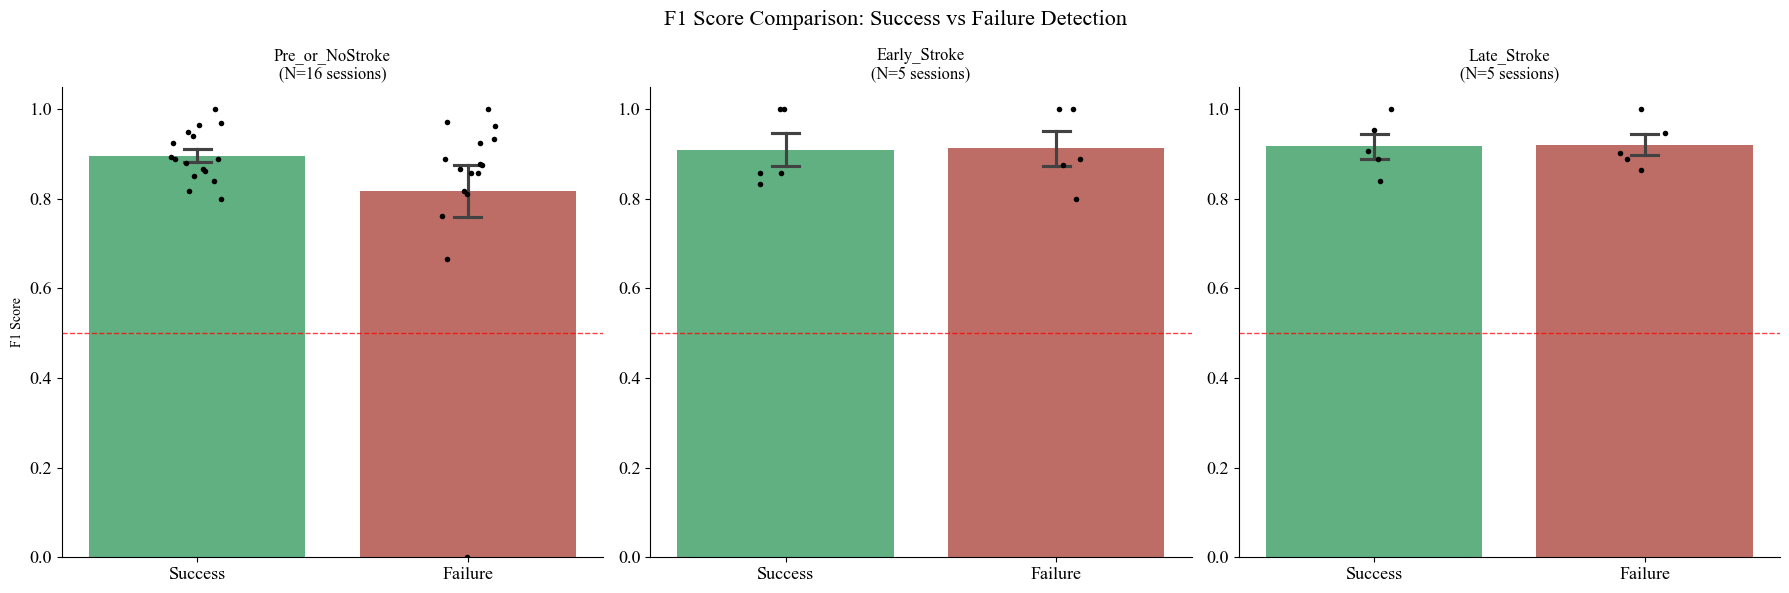

In [126]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, f_oneway, kruskal
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# SETUP: Extract data from comparison_results
# ============================================================================

# Extract metrics from comparison_results
results_list = []
for filename, row in comparison_results_balanced['results_per_file'].iterrows():
    # Calculate precision for F1 score
    precision_s = row['cm_ss'] / (row['cm_ss'] + row['cm_fs']) if (row['cm_ss'] + row['cm_fs']) > 0 else 0
    precision_f = row['cm_ff'] / (row['cm_ff'] + row['cm_sf']) if (row['cm_ff'] + row['cm_sf']) > 0 else 0
    
    # Calculate recall for F1 score
    recall_s = row['cm_ss'] / (row['cm_sf'] + row['cm_ss']) if (row['cm_sf'] + row['cm_ss']) > 0 else 0
    recall_f = row['cm_ff'] / (row['cm_ff'] + row['cm_fs']) if (row['cm_ff'] + row['cm_fs']) > 0 else 0
    
    # Calculate F1 scores
    f1_s = 2 * (precision_s * recall_s) / (precision_s + recall_s) if (precision_s + recall_s) > 0 else 0
    f1_f = 2 * (precision_f * recall_f) / (precision_f + recall_f) if (precision_f + recall_f) > 0 else 0
    
    results_list.append({
        'filename': row['filename'],
        'recall_s': f1_s,  # Using recall column name but storing F1
        'recall_f': f1_f,  # Using recall column name but storing F1
    })

df_merged = pd.DataFrame(results_list)

# Merge with groups
df_merged = df_merged.merge(df_gemini[['filename', 'phase', 'Stroke']], on='filename', how='left')

# Create groups
df_merged["group"] = "Other"
df_merged.loc[(df_merged["phase"] == "Pre_Stroke") | (df_merged["Stroke"] == "n"), "group"] = "Pre_or_NoStroke"
df_merged.loc[(df_merged["phase"] == "early") & (df_merged["Stroke"] == "y"), "group"] = "Early_Stroke"
df_merged.loc[(df_merged["phase"] == "Late") & (df_merged["Stroke"] == "y"), "group"] = "Late_Stroke"

# Melt for BOTH f1_s and f1_f
df_melt_recall = df_merged.melt(
    id_vars=["filename", "group", "phase", "Stroke"],
    value_vars=["recall_s", "recall_f"],
    var_name="metric",
    value_name="recall"
)

# Extract class from metric name
df_melt_recall["class"] = df_melt_recall["metric"].str.split("_").str[1]  # s or f

# Map class labels
class_map = {"s": "Success", "f": "Failure"}
df_melt_recall["class_label"] = df_melt_recall["class"].map(class_map)

# Filter to only include the three groups
group_order = ["Pre_or_NoStroke", "Early_Stroke", "Late_Stroke"]
df_melt_recall = df_melt_recall[df_melt_recall["group"].isin(group_order)]

# Drop NaN values
df_melt_recall = df_melt_recall.dropna(subset=["recall"])

print("="*80)
print("F1 SCORE COMPARISON: Person 2 vs Person 1 (Gold Standard)")
print("="*80)
print(f"\nTotal observations: {len(df_melt_recall)}")
print(f"Classes: {df_melt_recall['class_label'].unique()}")
print(f"Groups: {df_melt_recall['group'].unique()}")


# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("Creating visualization...")
print("="*80)
plt.rcParams['font.family'] = 'Times New Roman'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('F1 Score Comparison: Success vs Failure Detection', 
             fontsize=16)

# Color palette for classes
class_colors = {
    "Success": "#27ae60",  # Deeper green
    "Failure": "#c0392b"   # Deeper red
}

for i, group in enumerate(group_order):
    ax = axes[i]
    
    # Filter data for this group
    group_data = df_melt_recall[df_melt_recall["group"] == group]
    
    # Bar plot with class as hue
    sns.barplot(
        data=group_data,
        x="class_label",
        y="recall",
        hue="class_label",
        order=["Success", "Failure"],
        palette=class_colors,
        errorbar="se",
        capsize=0.1,
        ax=ax,
        alpha=0.8,
        legend=False
    )
    
    # Scatter individual points
    sns.stripplot(
        data=group_data,
        x="class_label",
        y="recall",
        order=["Success", "Failure"],
        jitter=True,
        size=4,
        color='black',
        ax=ax
    )
    
    # Styling
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.75)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("F1 Score" if i == 0 else "")
    ax.set_xlabel("")
    
    # Add sample size in title
    n_sessions = group_data.groupby("filename").ngroups
    ax.set_title(f"{group}\n(N={n_sessions} sessions)", fontsize=12)

    # Rotate x labels
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    
    sns.despine(ax=ax)

plt.tight_layout()
plt.savefig('interperson_f1_score_comparison.svg', dpi=300, bbox_inches='tight')
plt.savefig('interperson_f1_score_comparison.png', dpi=300, bbox_inches='tight')

print("Visualization saved: interperson_f1_score_comparison.svg/png")


# ============================================================================
# STATISTICAL ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("STATISTICAL TESTS BY GROUP")
print("="*80)

for group in group_order:
    print(f"\n{'='*80}")
    print(f"{group}")
    print('='*80)
    
    group_data = df_melt_recall[df_melt_recall["group"] == group]
    
    # Compare Success vs Failure F1 score
    success_data = group_data[group_data["class_label"] == "Success"]["recall"].dropna()
    failure_data = group_data[group_data["class_label"] == "Failure"]["recall"].dropna()
    
    print(f"\nSuccess F1 Score: mean={success_data.mean():.3f}, sem={success_data.sem():.3f}, n={len(success_data)}")
    print(f"Failure F1 Score: mean={failure_data.mean():.3f}, sem={failure_data.sem():.3f}, n={len(failure_data)}")
    
    if len(success_data) >= 3 and len(failure_data) >= 3:
        from scipy.stats import mannwhitneyu
        u_stat, p_value = mannwhitneyu(success_data, failure_data, alternative='two-sided')
        
        print(f"\nMann-Whitney U Test:")
        print(f"  U-statistic: {u_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print(f"  ✓ Significant difference (p < 0.05)")
        else:
            print(f"  ✗ No significant difference (p ≥ 0.05)")


print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

/tmp/ipykernel_1730669/3373925328.py:79: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
/tmp/ipykernel_1730669/3373925328.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='center')


✅ Plot saved to person2_performance_balanced_f1.svg


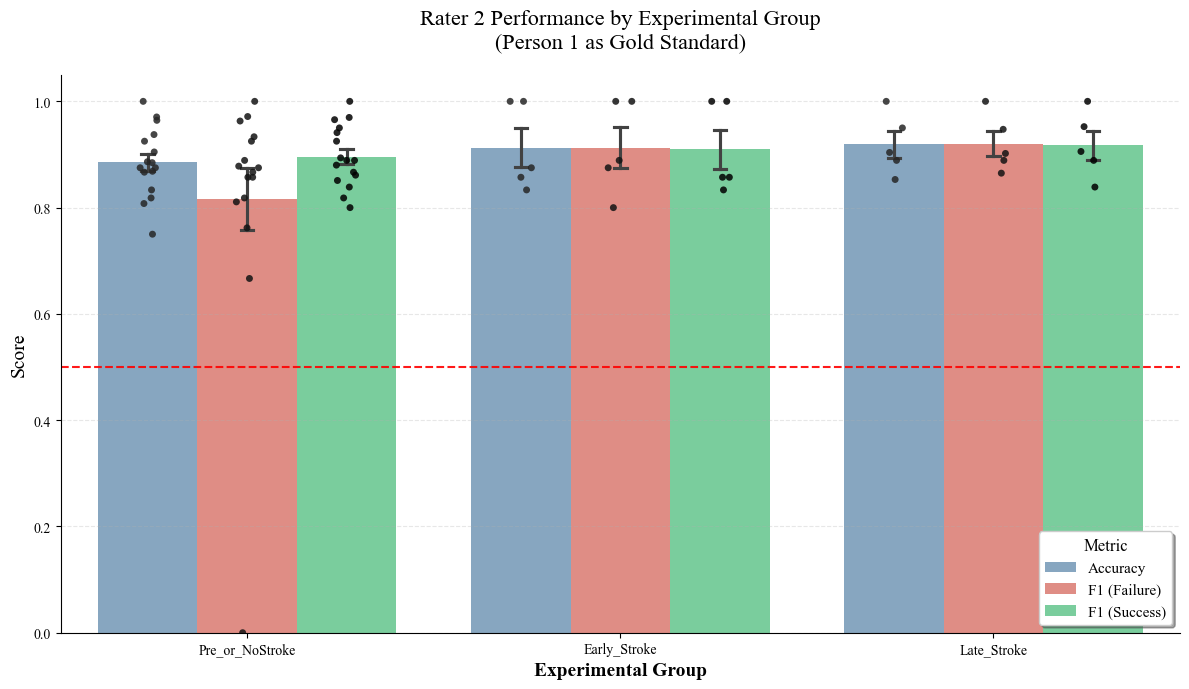

In [127]:
def plot_person2_combined_metrics(comparison_results, groups_df, save_path=None):
    """
    Alternative: Single plot with all three metrics side-by-side for each group.
    """
    # Set Times New Roman font
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # Calculate performance metrics with F1 scores
    results_df = comparison_results['results_per_file'].copy()
    
    # Calculate accuracy
    results_df['person2_accuracy'] = results_df['accuracy']
    
    # Calculate precision for F1 score
    results_df['precision_s'] = results_df['cm_ss'] / (results_df['cm_ss'] + results_df['cm_fs'])
    results_df['precision_f'] = results_df['cm_ff'] / (results_df['cm_ff'] + results_df['cm_sf'])
    
    # Calculate recall for F1 score
    results_df['recall_s'] = results_df['cm_ss'] / (results_df['cm_sf'] + results_df['cm_ss'])
    results_df['recall_f'] = results_df['cm_ff'] / (results_df['cm_ff'] + results_df['cm_fs'])
    
    # Calculate F1 scores
    results_df['f1_s'] = 2 * (results_df['precision_s'] * results_df['recall_s']) / (results_df['precision_s'] + results_df['recall_s'])
    results_df['f1_f'] = 2 * (results_df['precision_f'] * results_df['recall_f']) / (results_df['precision_f'] + results_df['recall_f'])
    
    # Handle division by zero
    results_df['f1_s'] = results_df['f1_s'].fillna(0)
    results_df['f1_f'] = results_df['f1_f'].fillna(0)
    
    # Merge with groups
    merged = results_df.merge(groups_df, on='filename', how='left')
    
    # Create combined group
    merged['group'] = 'Other'
    merged.loc[(merged['phase'] == 'Pre_Stroke') | (merged['Stroke'] == 'n'), 'group'] = 'Pre_or_NoStroke'
    merged.loc[(merged['phase'] == 'early') & (merged['Stroke'] == 'y'), 'group'] = 'Early_Stroke'
    merged.loc[(merged['phase'] == 'Late') & (merged['Stroke'] == 'y'), 'group'] = 'Late_Stroke'
    
    # Define group order
    group_order = ['Pre_or_NoStroke', 'Early_Stroke', 'Late_Stroke']
    
    # Filter to groups
    plot_data = merged[merged['group'].isin(group_order)]
    
    # Melt data for plotting - using F1 scores instead of recall
    plot_data_melt = plot_data.melt(
        id_vars=['filename', 'group'],
        value_vars=['person2_accuracy', 'f1_f', 'f1_s'],
        var_name='metric',
        value_name='value'
    )
    
    # Rename metrics
    metric_names = {
        'person2_accuracy': 'Accuracy',
        'f1_f': 'F1 (Failure)',
        'f1_s': 'F1 (Success)'
    }
    plot_data_melt['metric'] = plot_data_melt['metric'].map(metric_names)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Bar plot with error bars
    sns.barplot(
        data=plot_data_melt,
        x='group',
        y='value',
        hue='metric',
        order=group_order,
        errorbar='se',
        capsize=0.1,
        palette=['steelblue', '#e74c3c', '#2ecc71'],
        alpha=0.7,
        ax=ax
    )
    
    # Scatter individual points
    sns.stripplot(
        data=plot_data_melt,
        x='group',
        y='value',
        hue='metric',
        order=group_order,
        dodge=True,
        jitter=True,
        alpha=0.85,
        size=5,
        color='black',
        ax=ax,
        legend=False
    )
    
    # Styling
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.9)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_xlabel('Experimental Group', fontsize=14, fontweight='bold')
    ax.set_title('Rater 2 Performance by Experimental Group\n(Person 1 as Gold Standard)', 
                 fontsize=16, pad=20)
    ax.set_xticklabels(ax.get_xticklabels(), ha='center')
    ax.set_ylim(0, 1.05)
    ax.legend(title='Metric', fontsize=11, title_fontsize=12, loc='lower right', frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    sns.despine(ax=ax)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()


# Usage with balanced comparison results
plot_person2_combined_metrics(
    comparison_results_balanced, 
    df_gemini,
    save_path='person2_performance_balanced_f1.svg'
)


DEBUG: Sample F1 scores
                 filename      f1_s      f1_f  person2_accuracy
0  AZ_L3_2024-11-22_1.csv  0.800000  0.666667          0.750000
1  AZ_L3_2024-12-16_1.csv  0.857143  0.888889          0.875000
2  AZ_L3_2024-12-29_1.csv  0.838710  0.864865          0.852941
3  AZ_R2_2024-11-22_1.csv  0.818182  0.818182          0.818182
4  AZ_R2_2024-12-14_1.csv  0.888889  0.857143          0.875000
5  AZ_R2_2024-12-29_1.csv  1.000000  1.000000          1.000000
6  FJ_L2_2024-06-29_1.csv  0.969697  0.971429          0.970588
7  FJ_L2_2024-07-15_1.csv  0.857143  0.800000          0.833333
8  FJ_L3_2024-06-29_1.csv  0.866667  0.866667          0.866667
9  FJ_L3_2024-07-15_1.csv  0.833333  0.875000          0.857143

DEBUG: F1 scores by group

Pre_or_NoStroke:
  n = 16
  F1 Success: mean=0.896, std=0.058
  F1 Failure: mean=0.817, std=0.233
  Accuracy: mean=0.885, std=0.065

Early_Stroke:
  n = 5
  F1 Success: mean=0.910, std=0.083
  F1 Failure: mean=0.913, std=0.087
  Accuracy: mean

/tmp/ipykernel_1730669/260918786.py:113: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
/tmp/ipykernel_1730669/260918786.py:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='center')


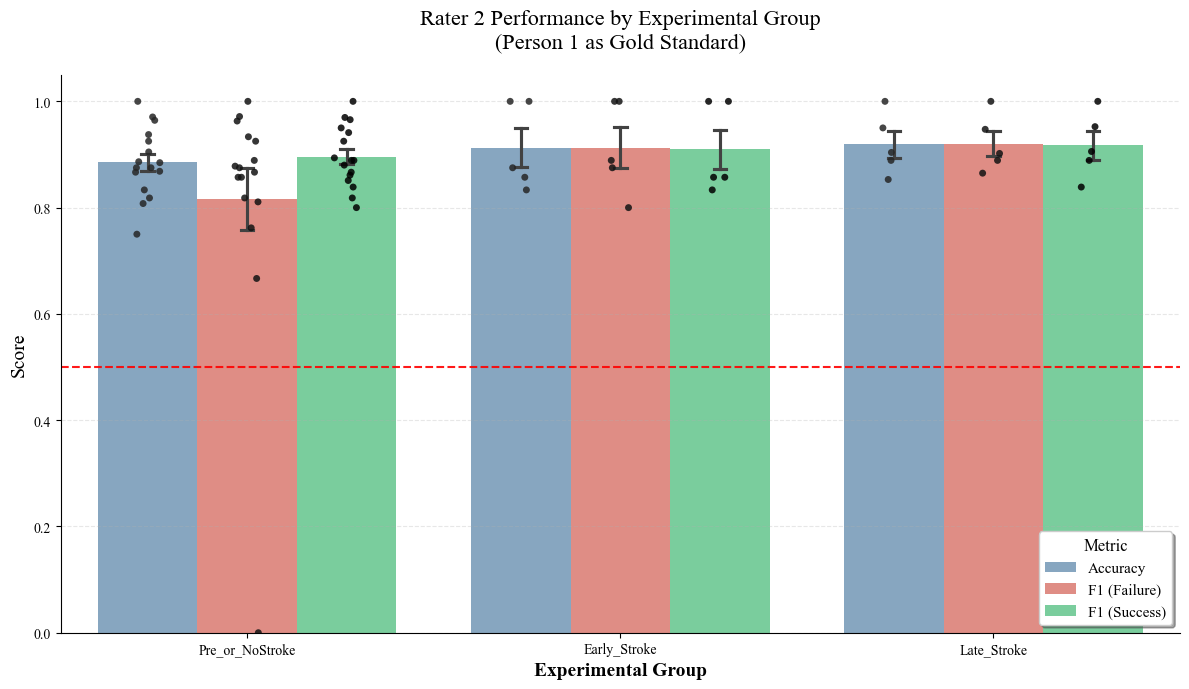

In [128]:
def plot_person2_combined_metrics(comparison_results, groups_df, save_path=None):
    """
    Alternative: Single plot with all three metrics side-by-side for each group.
    """
    # Set Times New Roman font
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # Calculate performance metrics with F1 scores
    results_df = comparison_results['results_per_file'].copy()
    
    # Calculate accuracy
    results_df['person2_accuracy'] = results_df['accuracy']
    
    # Calculate precision for F1 score (handling division by zero)
    results_df['precision_s'] = np.where(
        (results_df['cm_ss'] + results_df['cm_fs']) > 0,
        results_df['cm_ss'] / (results_df['cm_ss'] + results_df['cm_fs']),
        0
    )
    results_df['precision_f'] = np.where(
        (results_df['cm_ff'] + results_df['cm_sf']) > 0,
        results_df['cm_ff'] / (results_df['cm_ff'] + results_df['cm_sf']),
        0
    )
    
    # Calculate recall for F1 score (handling division by zero)
    results_df['recall_s'] = np.where(
        (results_df['cm_sf'] + results_df['cm_ss']) > 0,
        results_df['cm_ss'] / (results_df['cm_sf'] + results_df['cm_ss']),
        0
    )
    results_df['recall_f'] = np.where(
        (results_df['cm_ff'] + results_df['cm_fs']) > 0,
        results_df['cm_ff'] / (results_df['cm_ff'] + results_df['cm_fs']),
        0
    )
    
    # Calculate F1 scores (handling division by zero)
    results_df['f1_s'] = np.where(
        (results_df['precision_s'] + results_df['recall_s']) > 0,
        2 * (results_df['precision_s'] * results_df['recall_s']) / (results_df['precision_s'] + results_df['recall_s']),
        0
    )
    results_df['f1_f'] = np.where(
        (results_df['precision_f'] + results_df['recall_f']) > 0,
        2 * (results_df['precision_f'] * results_df['recall_f']) / (results_df['precision_f'] + results_df['recall_f']),
        0
    )
    
    # DEBUG: Print some values to check
    print("\nDEBUG: Sample F1 scores")
    print(results_df[['filename', 'f1_s', 'f1_f', 'person2_accuracy']].head(10))
    
    # Merge with groups
    merged = results_df.merge(groups_df, on='filename', how='left')
    
    # Create combined group
    merged['group'] = 'Other'
    merged.loc[(merged['phase'] == 'Pre_Stroke') | (merged['Stroke'] == 'n'), 'group'] = 'Pre_or_NoStroke'
    merged.loc[(merged['phase'] == 'early') & (merged['Stroke'] == 'y'), 'group'] = 'Early_Stroke'
    merged.loc[(merged['phase'] == 'Late') & (merged['Stroke'] == 'y'), 'group'] = 'Late_Stroke'
    
    # Define group order
    group_order = ['Pre_or_NoStroke', 'Early_Stroke', 'Late_Stroke']
    
    # Filter to groups
    plot_data = merged[merged['group'].isin(group_order)]
    
    # DEBUG: Check group counts and values
    print("\nDEBUG: F1 scores by group")
    for group in group_order:
        group_data = plot_data[plot_data['group'] == group]
        print(f"\n{group}:")
        print(f"  n = {len(group_data)}")
        print(f"  F1 Success: mean={group_data['f1_s'].mean():.3f}, std={group_data['f1_s'].std():.3f}")
        print(f"  F1 Failure: mean={group_data['f1_f'].mean():.3f}, std={group_data['f1_f'].std():.3f}")
        print(f"  Accuracy: mean={group_data['person2_accuracy'].mean():.3f}, std={group_data['person2_accuracy'].std():.3f}")
    
    # Melt data for plotting
    plot_data_melt = plot_data.melt(
        id_vars=['filename', 'group'],
        value_vars=['person2_accuracy', 'f1_f', 'f1_s'],
        var_name='metric',
        value_name='value'
    )
    
    # Rename metrics
    metric_names = {
        'person2_accuracy': 'Accuracy',
        'f1_f': 'F1 (Failure)',
        'f1_s': 'F1 (Success)'
    }
    plot_data_melt['metric'] = plot_data_melt['metric'].map(metric_names)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Bar plot with error bars
    sns.barplot(
        data=plot_data_melt,
        x='group',
        y='value',
        hue='metric',
        order=group_order,
        errorbar='se',
        capsize=0.1,
        palette=['steelblue', '#e74c3c', '#2ecc71'],
        alpha=0.7,
        ax=ax
    )
    
    # Scatter individual points
    sns.stripplot(
        data=plot_data_melt,
        x='group',
        y='value',
        hue='metric',
        order=group_order,
        dodge=True,
        jitter=True,
        alpha=0.85,
        size=5,
        color='black',
        ax=ax,
        legend=False
    )
    
    # Styling
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.9)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_xlabel('Experimental Group', fontsize=14, fontweight='bold')
    ax.set_title('Rater 2 Performance by Experimental Group\n(Person 1 as Gold Standard)', 
                 fontsize=16, pad=20)
    ax.set_xticklabels(ax.get_xticklabels(), ha='center')
    ax.set_ylim(0, 1.05)
    ax.legend(title='Metric', fontsize=11, title_fontsize=12, loc='lower right', frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    sns.despine(ax=ax)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()


# Usage
plot_person2_combined_metrics(
    comparison_results_balanced, 
    df_gemini,
    save_path='person2_performance_balanced_f1.svg'
)
